In [1]:
from parse_full_results import get_full_try_exps_dataframe
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['axes.titlesize']=12
plt.rcParams['axes.labelsize']=12
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = 14

plt.rcParams['axes.formatter.use_locale'] = True

In [2]:
#def handle_final_df(df):
#    df.loc[df.loader_size == -1, 'loader_size'] = 60000
#    df['training_full_size'] = df['num_epochs']*df['loader_size']

In [3]:
df = get_full_try_exps_dataframe()
df = df[df.loader_size == -1]

In [4]:
columns = df.columns
df.rename(columns = {'class':'model_class', 'num_samples':'samples_num'}, inplace=True)
df

model_class  train_loss  val_loss  train_acc   val_acc  deviation  \
0           conv    0.820361  0.911670   0.713075  0.682524   0.104189   
1           conv    0.275363  0.851077   0.912724  0.738854   0.061713   
2           conv    1.427615  1.440004   0.502118  0.489053   0.117319   
3           conv    0.068190  1.268307   0.976103  0.744228   0.033159   
4           conv    0.829290  0.936554   0.706102  0.663913   0.096814   
...          ...         ...       ...        ...       ...        ...   
5016     conv_bn    0.705360  0.829241   0.752937  0.715565   0.392519   
5017     conv_bn    0.887928  1.110837   0.693494  0.616640   0.239192   
5018     conv_bn    0.159992  0.630538   0.944513  0.816979   0.631182   
5019     conv_bn    0.875614  1.008923   0.690717  0.648587   0.253379   
5020     conv_bn    0.029416  1.883798   0.989510  0.733977   1.971149   

                    save_log_path  num_epochs  loader_size  layers_num  \
0              results/hc512/4_22           2           -1           4   
1              results/hc512/7_17           8           -1           3   
2              results/hc512/4_63           1           -1          10   
3              results/hc512/4_60          16           -1           9   
4              results/hc512/5_72           4           -1          11   
...                           ...         ...          ...         ...   
5016  results/conv_bn/hc_128/0_58           4           -1          16   
5017   results/conv_bn/hc_128/0_2           4           -1           1   
5018  results/conv_bn/hc_128/2_60          16           -1          16   
5019   results/conv_bn/hc_128/3_8           2           -1           2   
5020  results/conv_bn/hc_128/1_33          32           -1           5   

      hidden_channels  kernel_size  output_channels  num_params  sigma  \
0                 512            3                8     7202642      3   
1                 512            3                8     4842834      3   
2                 512            3                8    21361490      3   
3                 512            3                8    19001682      3   
4                 512            3                8    23721298      3   
...               ...          ...              ...         ...    ...   
5016              128            3                8     2302674      3   
5017              128            3                8       85074      3   
5018              128            3                8     2302674      3   
5019              128            3                8      232914      3   
5020              128            3                8      676434      3   

      samples_num  
0              32  
1              32  
2              32  
3              32  
4              32  
...           ...  
5016           32  
5017           32  
5018           32  
5019           32  
5020           32  

[5021 rows x 16 columns]

In [7]:
import pickle
with open(df.save_log_path[0] + '/deviations_.pickle', 'r') as f:
    x = pickle.load(f)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [5]:
def describe_exps(df, describe_in_column = None):
    if describe_in_column is not None:
        final_rows = []
        for target_col in np.unique(df[describe_in_column]):
            current_row = {describe_in_column:target_col}
            for column in ['num_epochs', 'layers_num', 'hidden_channels']:
                if column == describe_in_column:
                    continue
                current_row[f'unique {column}'] = len(np.unique(np.array(df.query(f'{describe_in_column} == {target_col}')[column])))
            final_rows.append(current_row)
        print(current_row.keys())
        display(pd.DataFrame(final_rows, columns = current_row.keys()))
    else:
        print(f'number of unique')
        for column in ['num_epochs', 'layers_num', 'hidden_channels']:
            print(column, ':', len(np.unique(np.array(df[column]))))
print()
describe_exps(df, describe_in_column='layers_num')
describe_exps(df, describe_in_column='hidden_channels')


dict_keys(['layers_num', 'unique num_epochs', 'unique hidden_channels'])


layers_num  unique num_epochs  unique hidden_channels
0            1                  7                       7
1            2                  7                       7
2            3                  7                       7
3            4                  7                       7
4            5                  7                       7
5            6                  7                       5
6            7                  7                       5
7            8                  7                       5
8            9                  7                       4
9           10                  7                       4
10          11                  7                       4
11          12                  7                       4
12          13                  7                       4
13          14                  7                       4
14          15                  7                       3
15          16                  7                       5

dict_keys(['hidden_channels', 'unique num_epochs', 'unique layers_num'])


hidden_channels  unique num_epochs  unique layers_num
0               64                  7                 16
1              128                  7                 16
2              256                  7                 15
3              512                  7                 16
4             1024                  7                  6
5             2048                  7                  8
6             4096                  7                  5

deviation = $mean_k((k+1)|\mathcal{L}_{k+1} - \mathcal{L}_k|)$ <br>
При этом данная величина усреднена по запускам (по 8 для каждого сетапа)

In [6]:
def compare_same_params(same_params_dict, 
                        target_params, 
                        supported_changes_params, 
                        df = df, 
                        enable_valid = True,
                        params_in_suptitle = None,
                        train_log_columns = ['train_loss', 'val_loss', 'train_acc', 'val_acc']):
    columns = list(same_params_dict.keys()) + [target_params] + ['deviation'] + train_log_columns + [supported_changes_params]
    def wrap(elem):
        if isinstance(elem, str):
            elem = '\"' + elem + '\"'
        return elem
    query = ' and '.join([f'{key} == {wrap(value)}' for key, value in same_params_dict.items()])
    df = df[columns].query(query)
    fig, axs = plt.subplots(3, figsize = (15, 12))
    if params_in_suptitle is not None:
        fig.suptitle([f'{key}:{same_params_dict[key]}' for key in params_in_suptitle])
    colors = sns.color_palette()
    mod = len(colors)
    for i, supported_param in enumerate(np.unique(df[supported_changes_params])):
        df_with_supported = copy.deepcopy(df)
        df_with_supported.query(f'{supported_changes_params} == {supported_param}', inplace = True)
        sns.pointplot(
            x=target_params, 
            y='deviation',
            data=df_with_supported, ax = axs[0], 
            label = supported_param, 
            color = colors[i%mod])
        if 'train_loss' in train_log_columns:
            sns.pointplot(
                x=target_params, 
                y='train_loss', 
                data=df_with_supported, ax = axs[1], 
                label = f'{supported_param}',
                color = colors[i%mod]);
        if 'val_loss' in train_log_columns:
            if enable_valid:
                sns.pointplot(
                    x=target_params, 
                    y='val_loss', 
                    data=df_with_supported, ax = axs[1],
                    color = colors[i%mod]);
        if 'train_acc' in train_log_columns:
            sns.pointplot(
                x=target_params, 
                y='train_acc', 
                data=df_with_supported, 
                ax = axs[2], 
                label= f'{supported_param}',
                color = colors[i%mod]
            );
        if 'val_acc' in train_log_columns:
            if enable_valid:
                sns.pointplot(
                    x=target_params, 
                    y='val_acc', 
                    data=df_with_supported, 
                    ax = axs[2], 
                    color = colors[i%mod]);

    for i in range(3):
        axs[i].legend(title = supported_changes_params)
    axs[1].set_ylabel('Loss')
    axs[2].set_ylabel('Accuracy')


#### Строю train/valid, при этом одним цветом помечаю одну и ту же модель для train и valid <br>
Отдаельно не подписываю valid

In [68]:
conv_bn_path = df.query('model_class == \"conv_bn\" and num_epochs == 64 and layers_num == 4 and hidden_channels == 512').iloc[0].save_log_path
conv_path = df.query('model_class == \"conv\" and num_epochs == 64 and layers_num == 4 and hidden_channels == 512').iloc[0].save_log_path

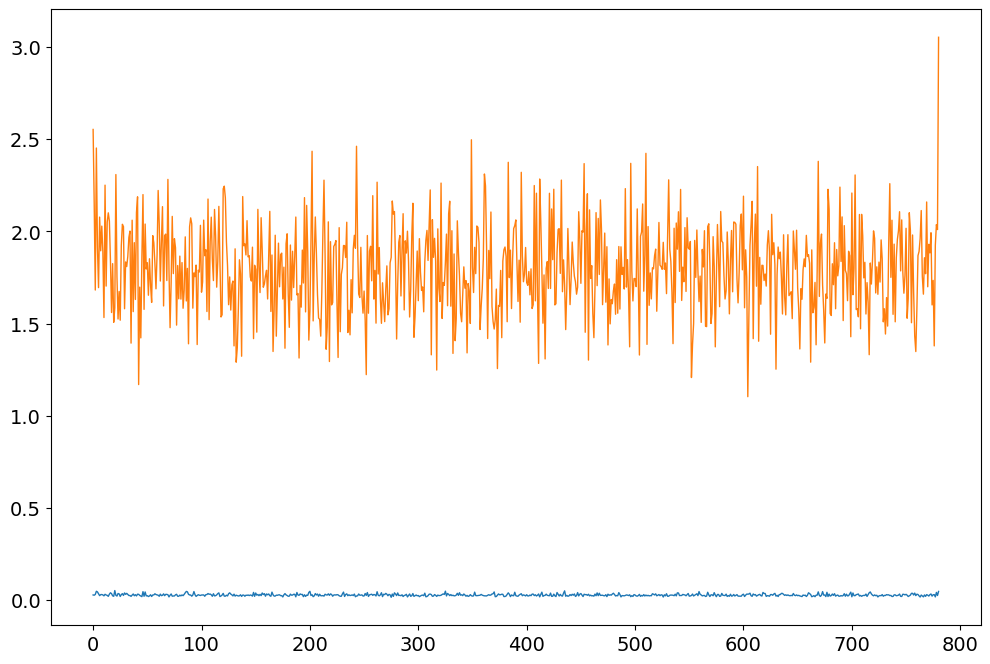

In [81]:
import pickle
import json
import pandas as pd
import _pickle as cPickle

#fig, ax = plt.subplots(figsize = (12, 8))
#conv_train_lossses = pd.read_pickle(f'{conv_path}/train_losses_.pickle')
#ax.plot(conv_train_lossses, label = 'no_bn')
#conv_bn_train_lossses = pd.read_pickle(f'{conv_bn_path}/train_losses_.pickle')
#ax.plot(conv_bn_train_lossses, label = 'bn')



fig, ax = plt.subplots(figsize = (12, 8))
conv_train_deviations = pd.read_pickle(f'{conv_path}/deviations_.pickle')
ax.plot(conv_train_deviations, label = 'no_bn')
conv_bn_train_deviations = pd.read_pickle(f'{conv_bn_path}/deviations_.pickle')
ax.plot(conv_bn_train_deviations, label = 'bn')

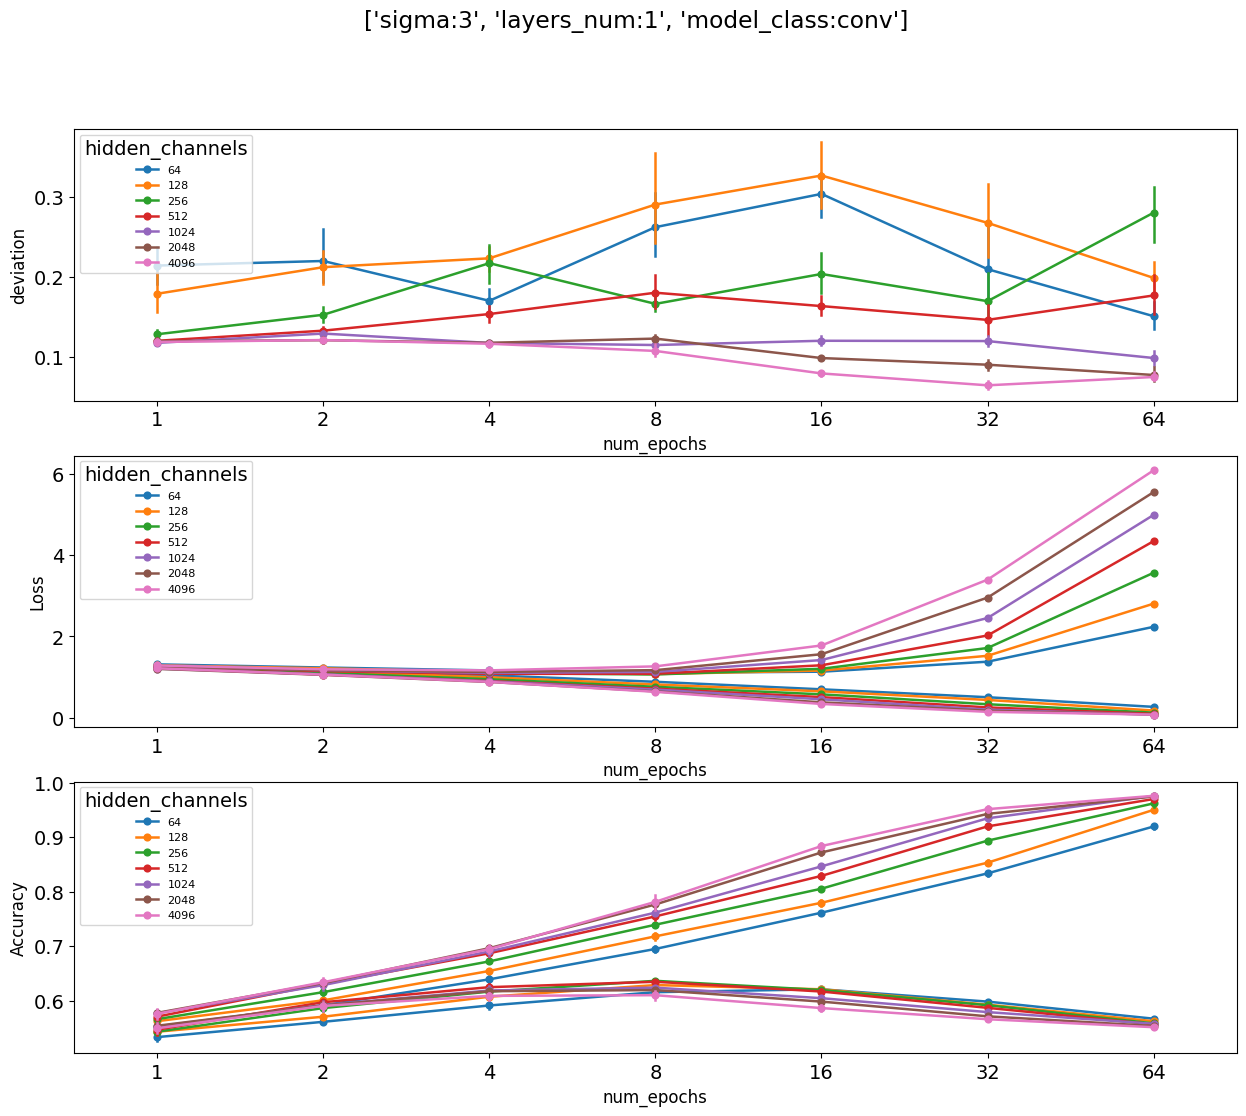

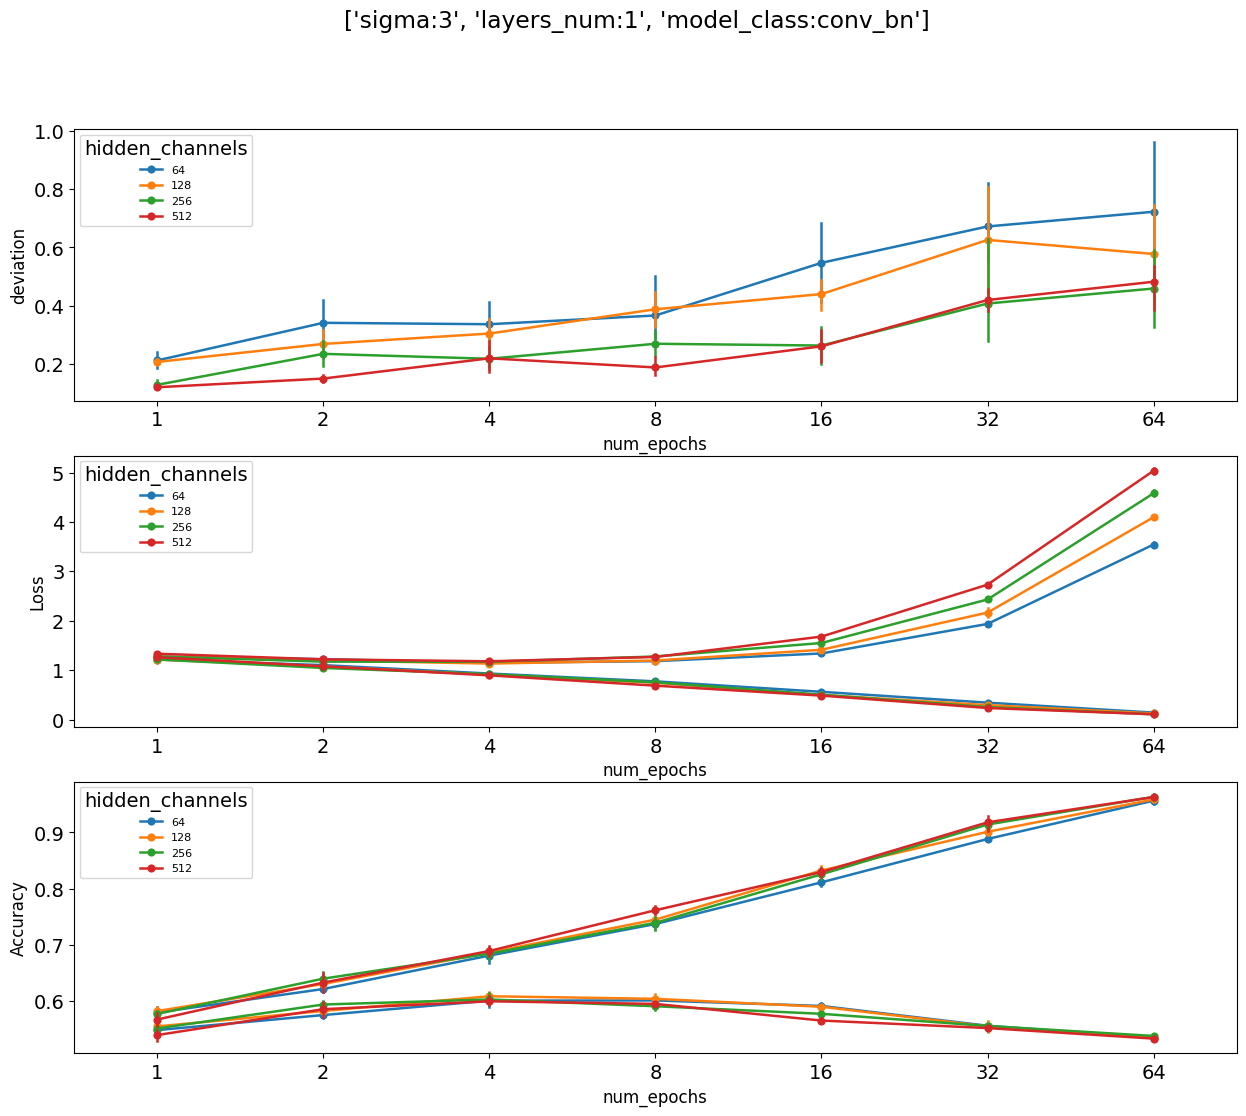

In [7]:
same_params = {
    'model_class':'conv',
    
    'layers_num':1,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'hidden_channels'
compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params, 
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

same_params = {
    'model_class':'conv_bn',
    
    'layers_num':1,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'hidden_channels'
compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params, 
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

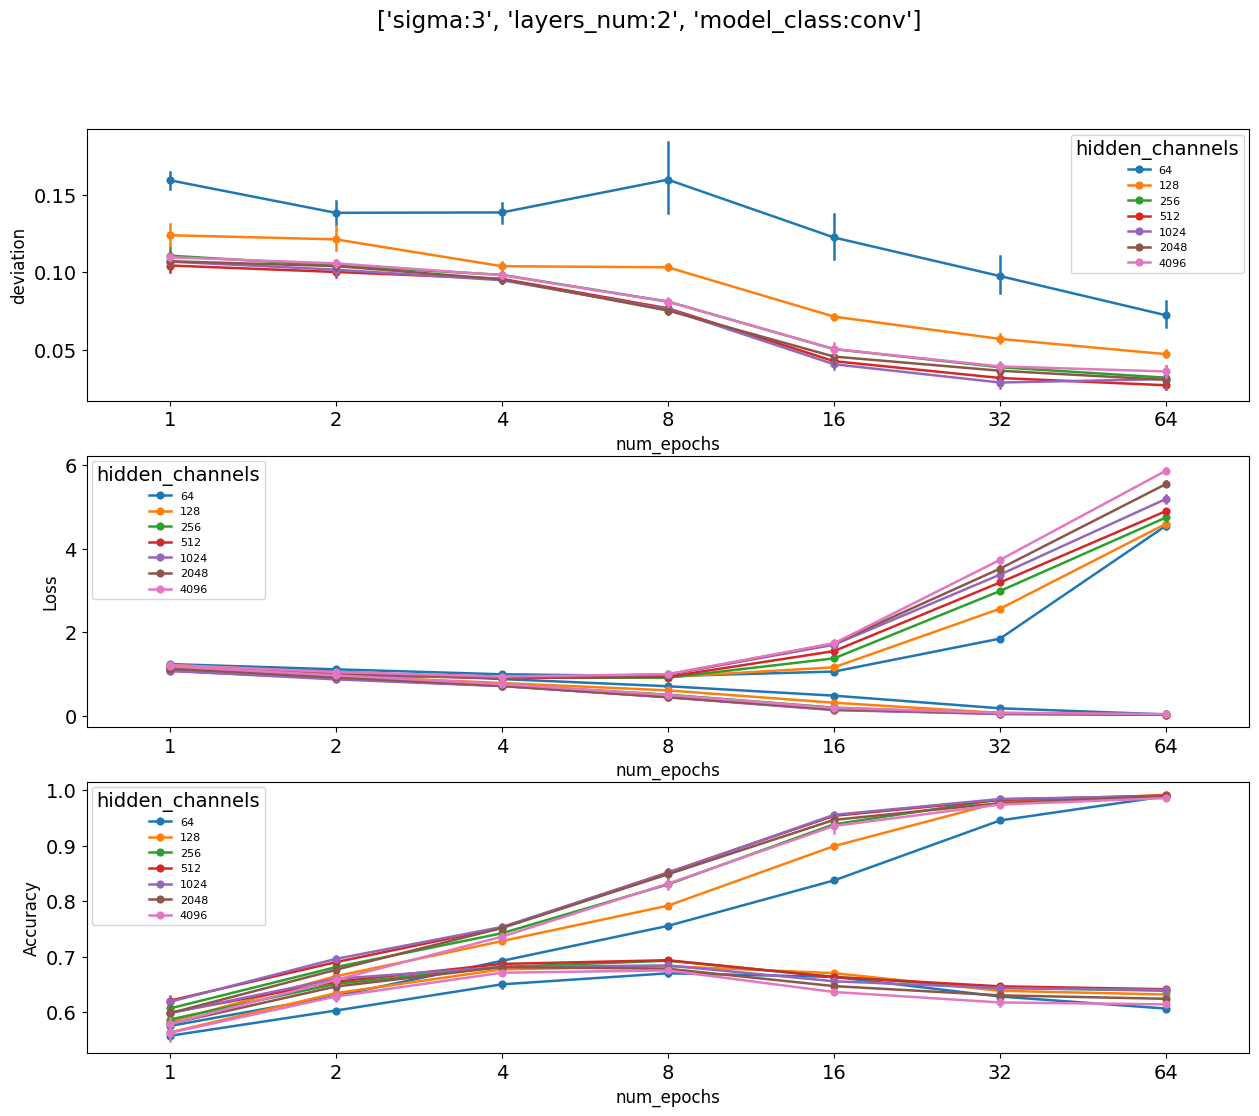

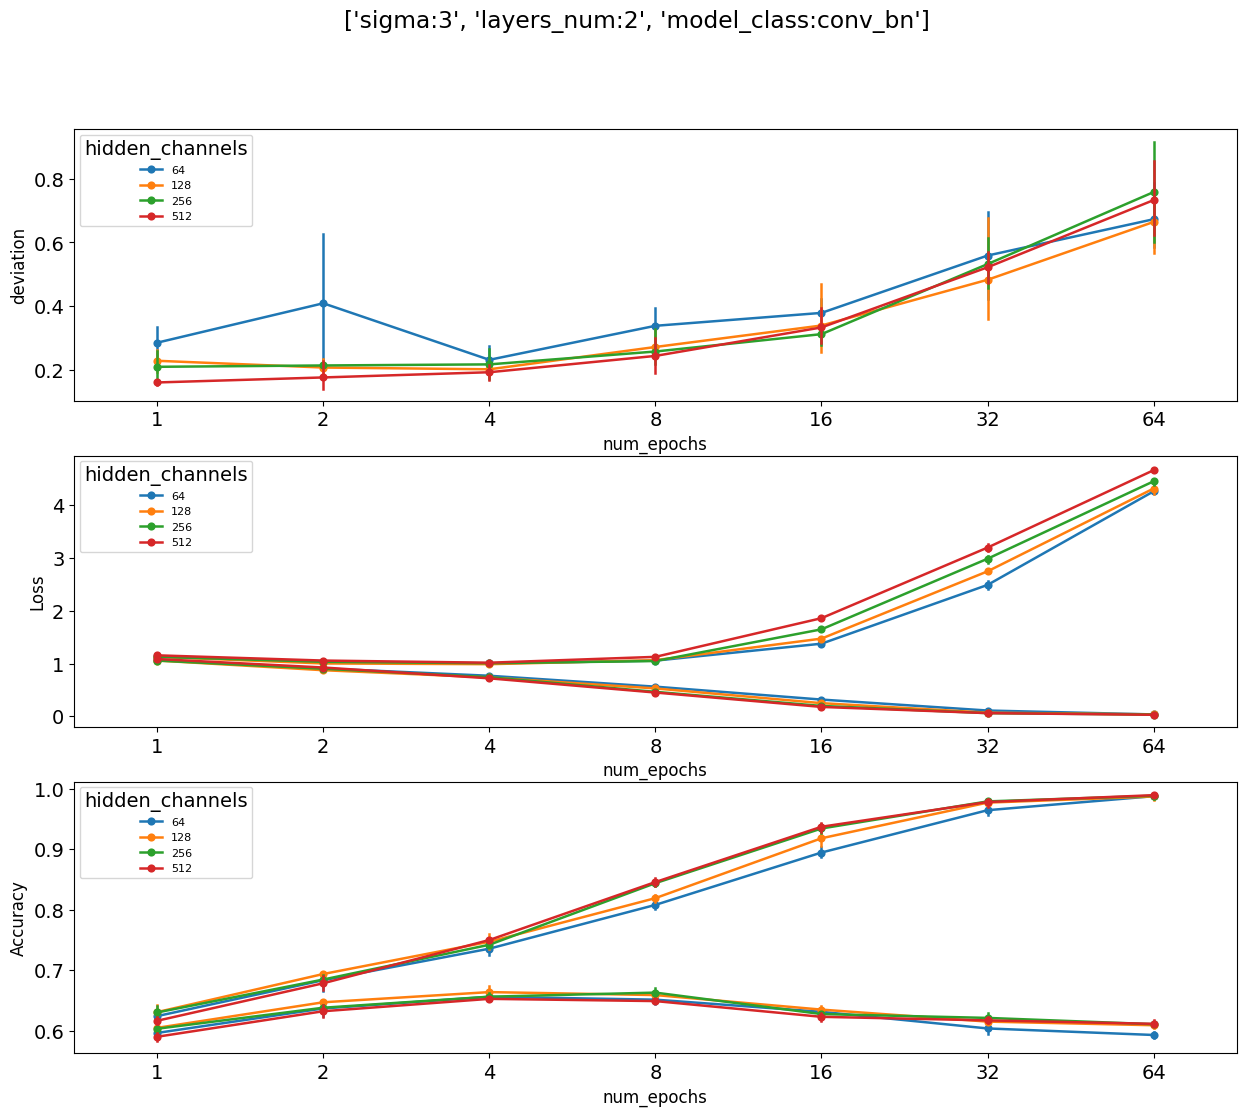

In [8]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'layers_num':2,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'hidden_channels'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params, 
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

same_params = {
    'model_class':'conv_bn',
    
    'loader_size':-1,
    'layers_num':2,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'hidden_channels'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params, 
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

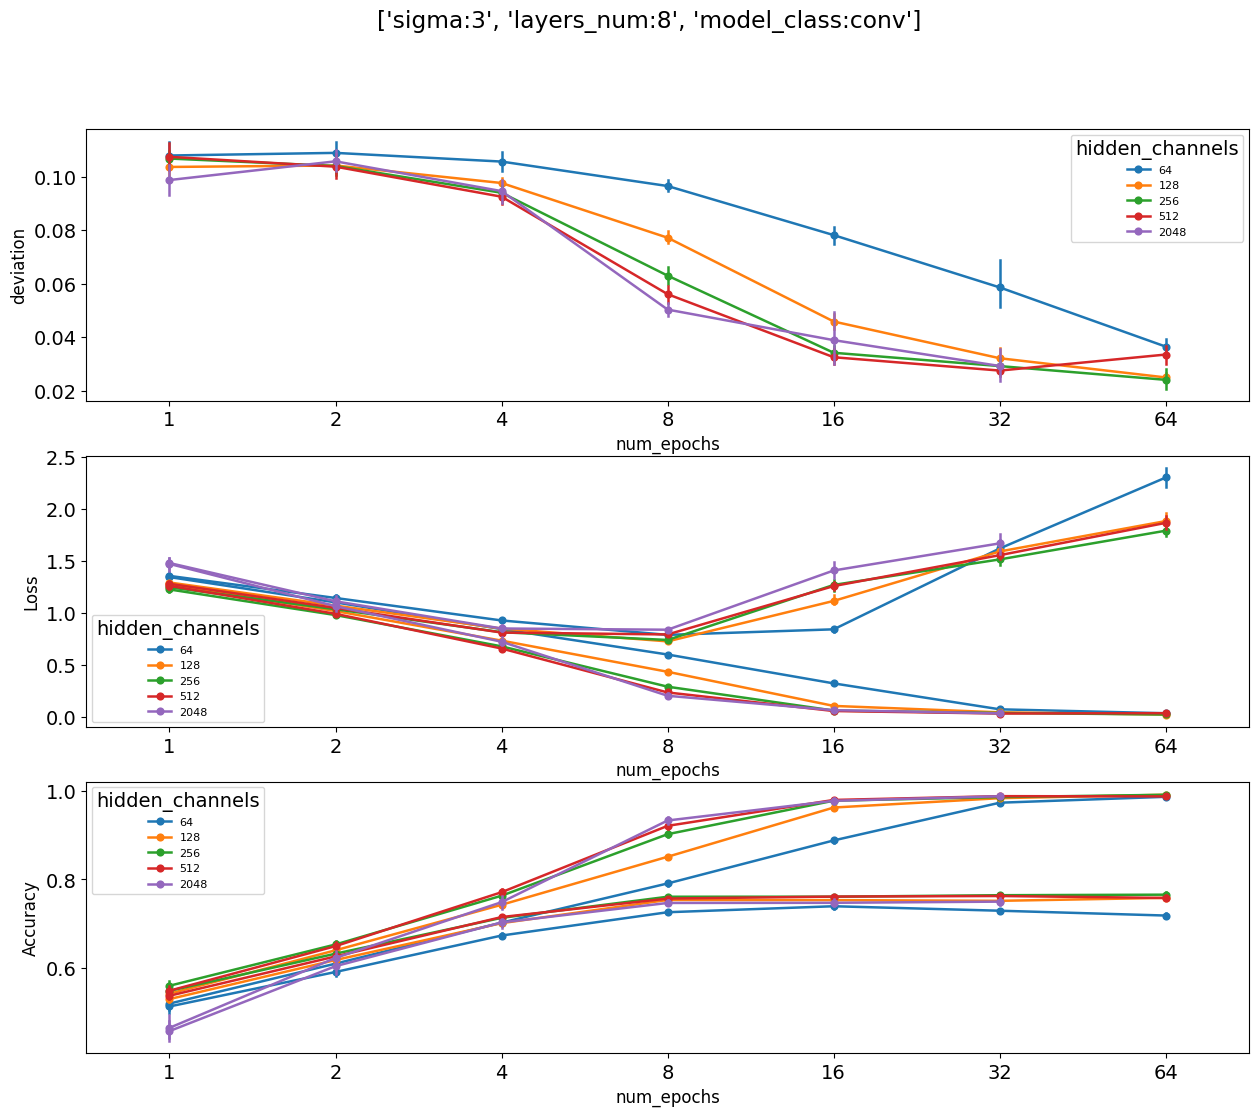

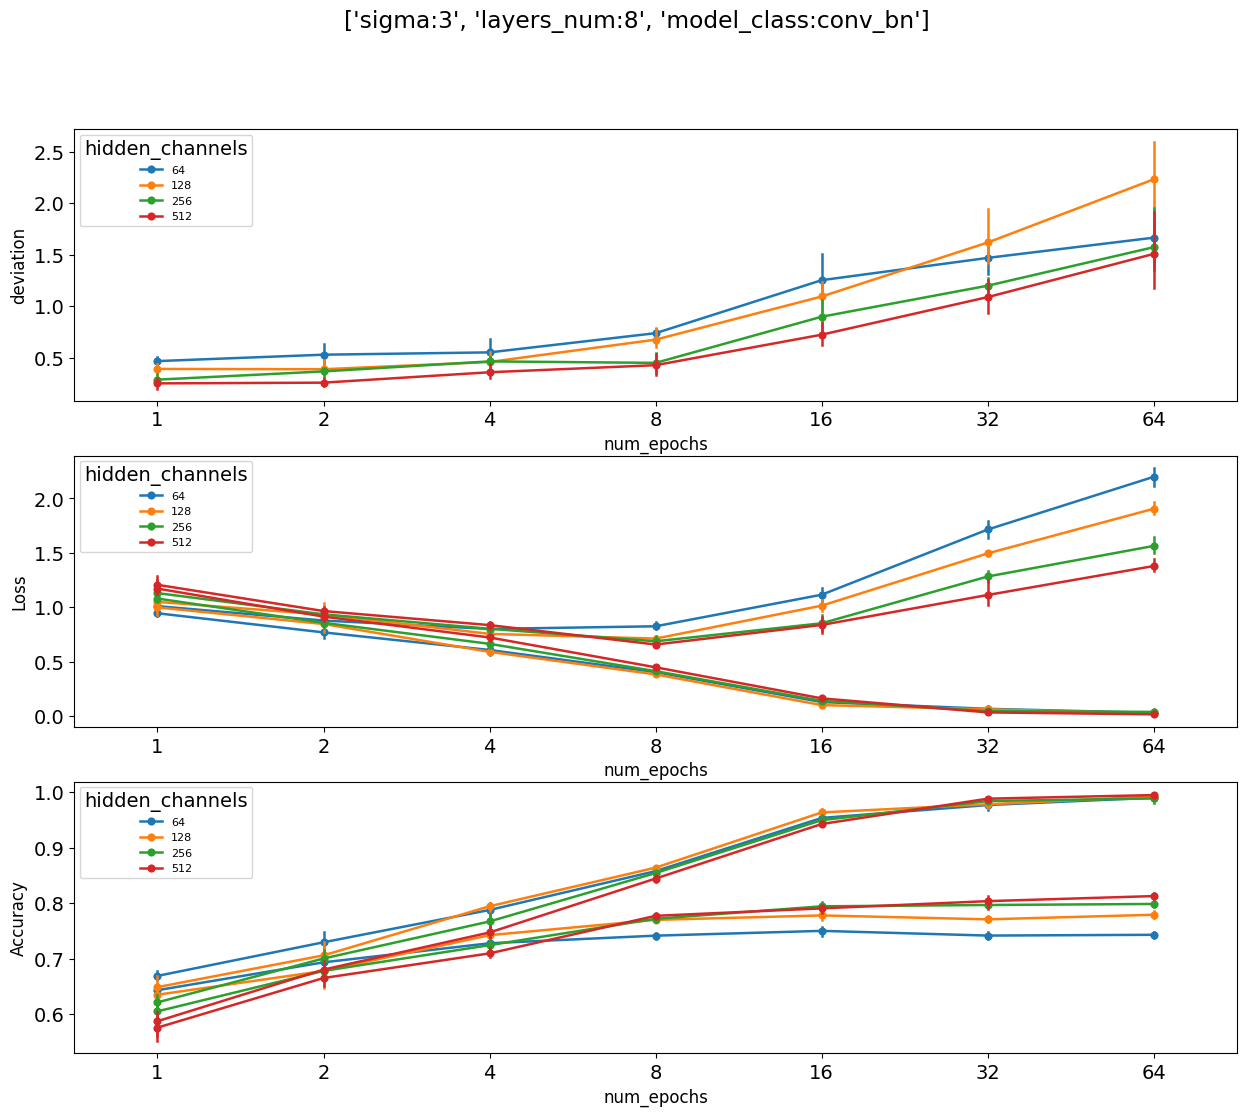

In [9]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'layers_num':8,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'hidden_channels'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params, 
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

same_params = {
    'model_class':'conv_bn',
    
    'loader_size':-1,
    'layers_num':8,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'hidden_channels'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params, 
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

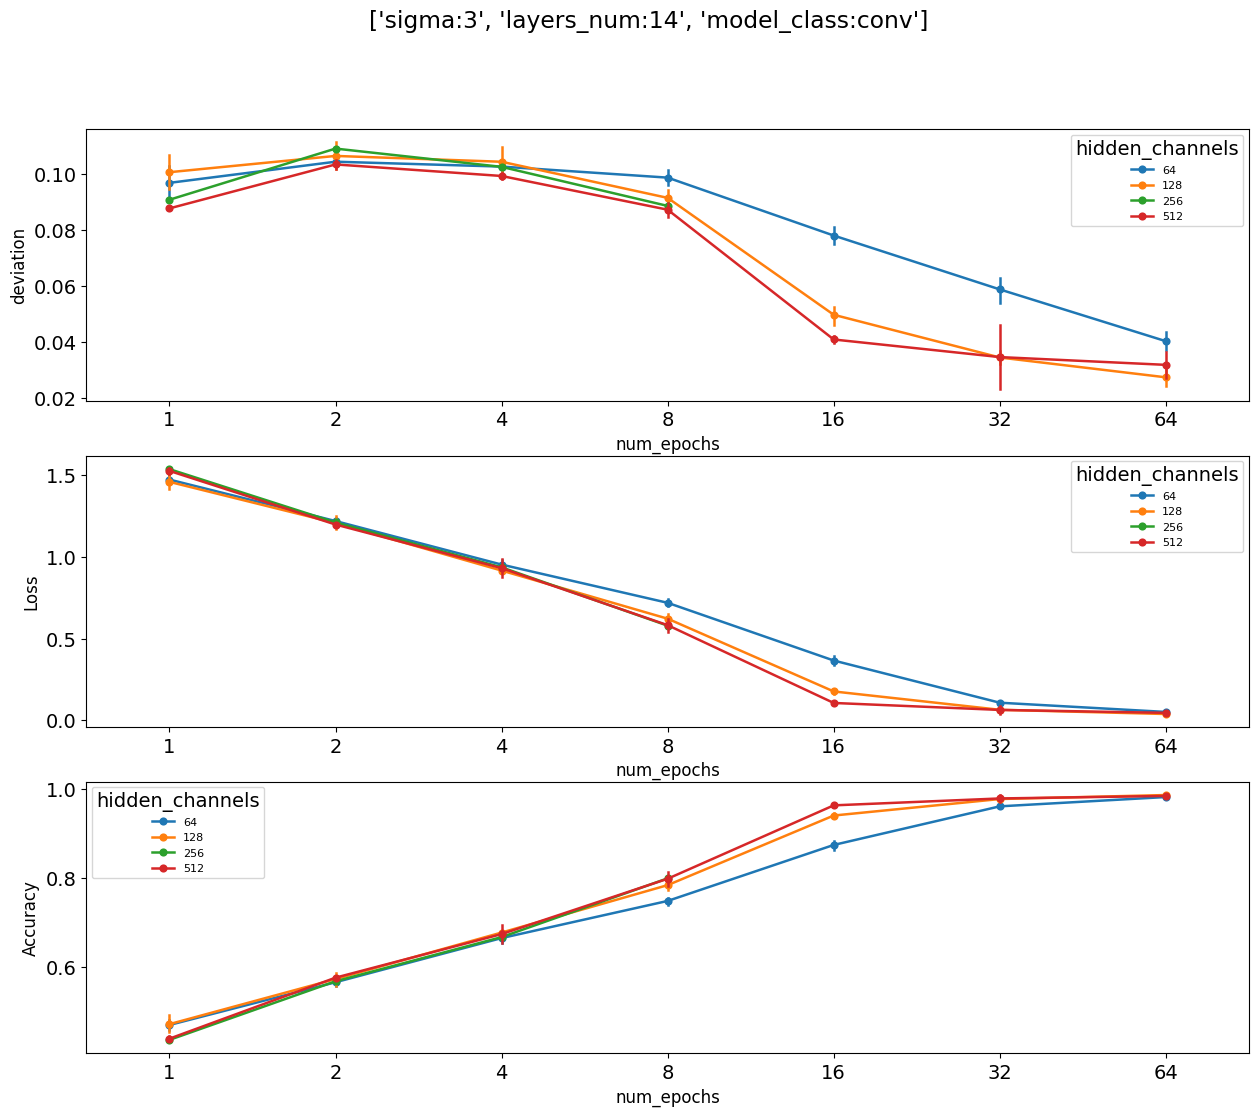

In [11]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'layers_num':14,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'hidden_channels'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

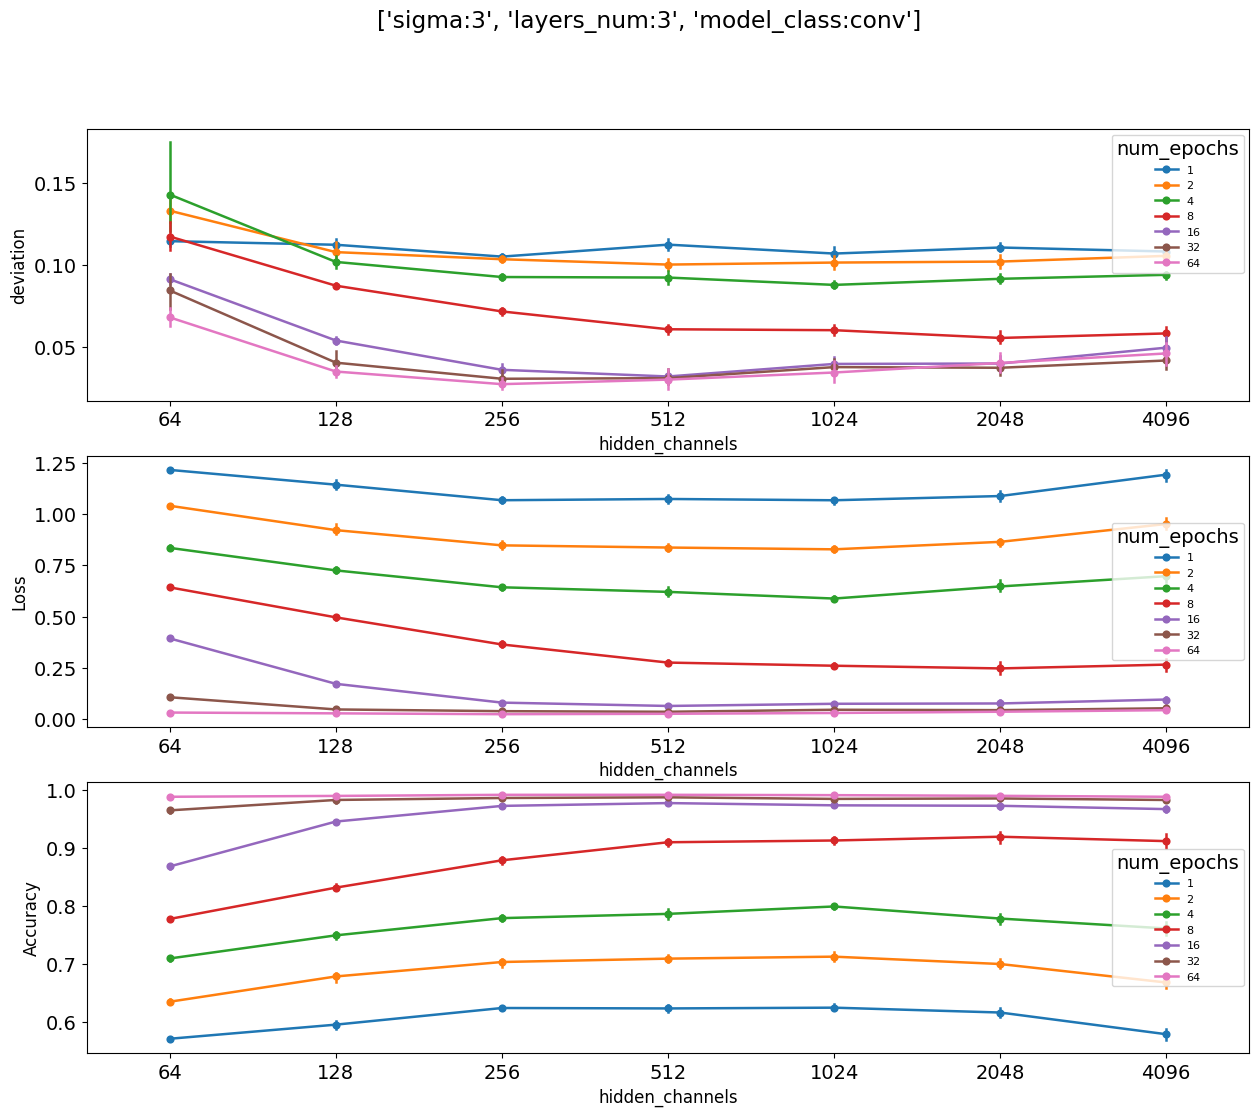

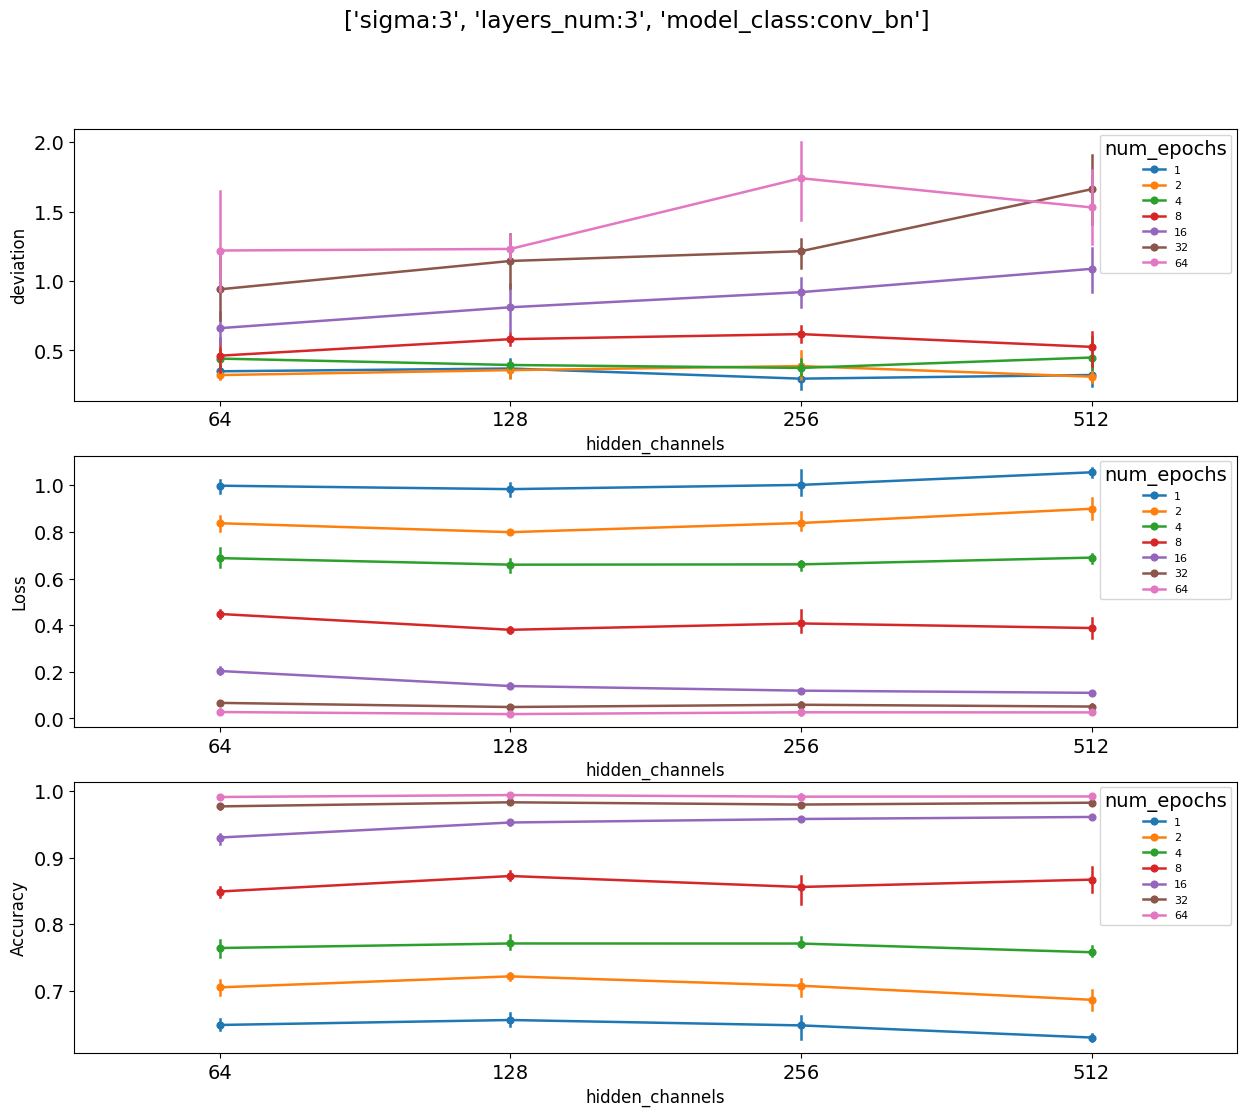

In [12]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'layers_num':3,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'hidden_channels'
supported_changes_params = 'num_epochs'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

same_params = {
    'model_class':'conv_bn',
    
    'loader_size':-1,
    'layers_num':3,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'hidden_channels'
supported_changes_params = 'num_epochs'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'layers_num', 'model_class'])

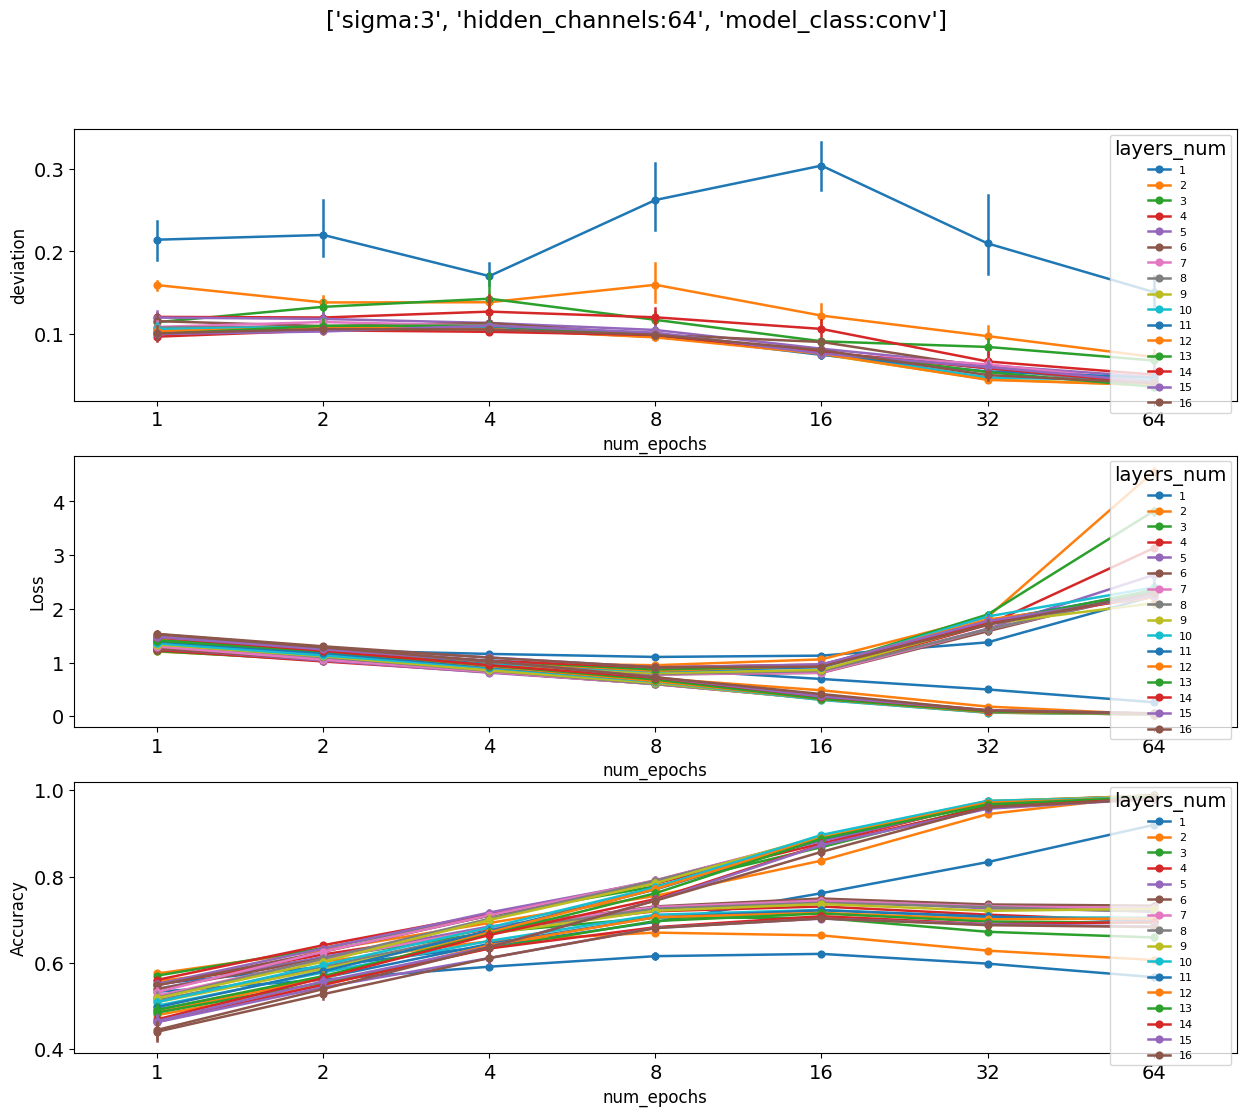

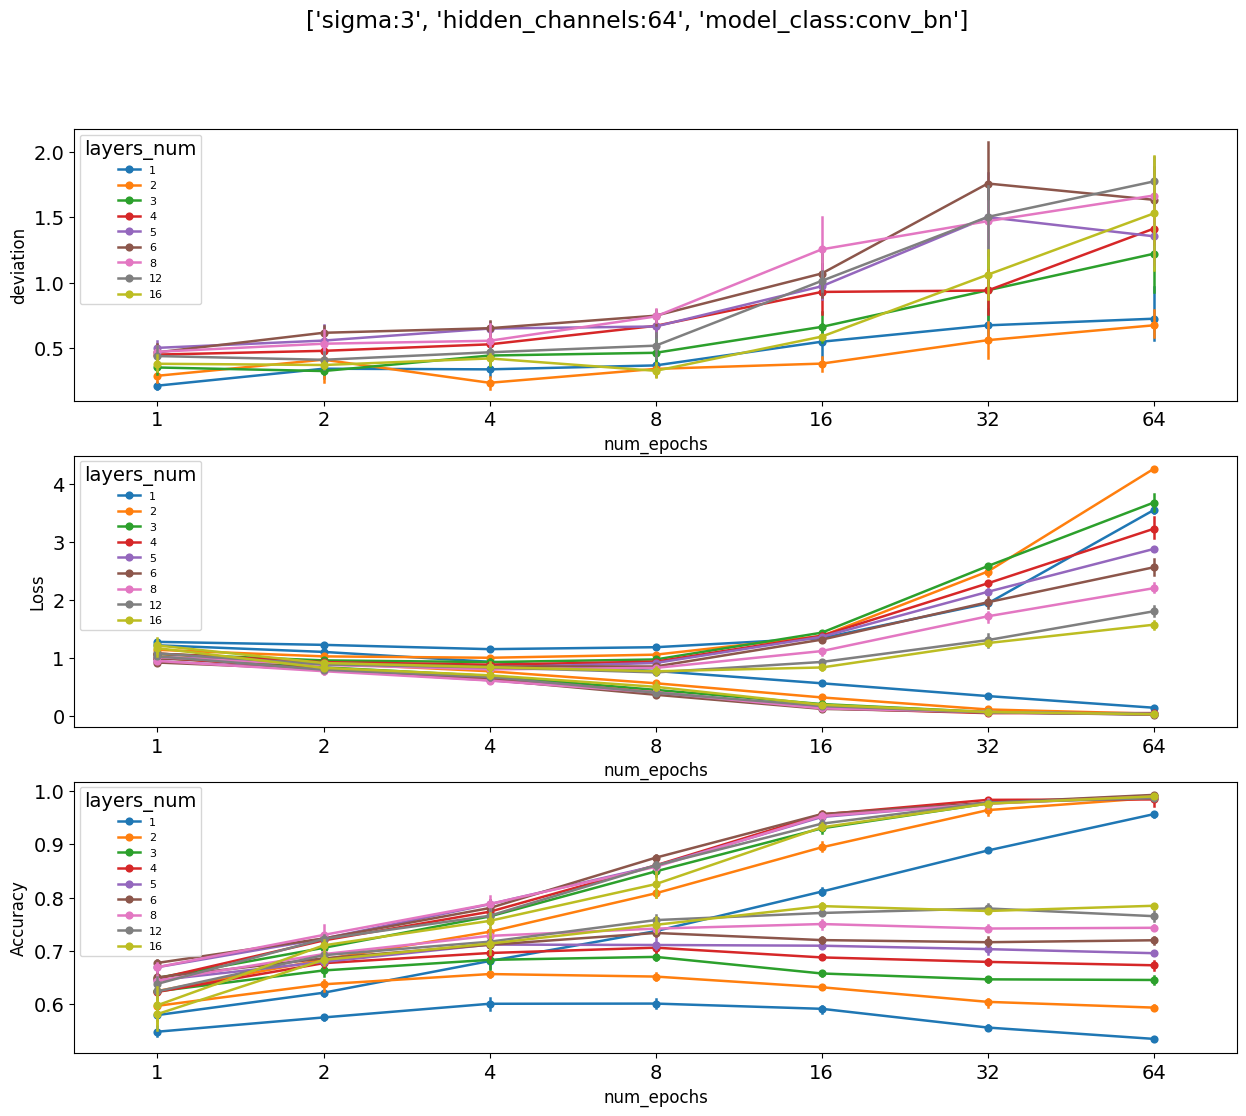

In [24]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'hidden_channels':64,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'layers_num'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])


same_params = {
    'model_class':'conv_bn',
    
    'loader_size':-1,
    'hidden_channels':64,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'layers_num'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])

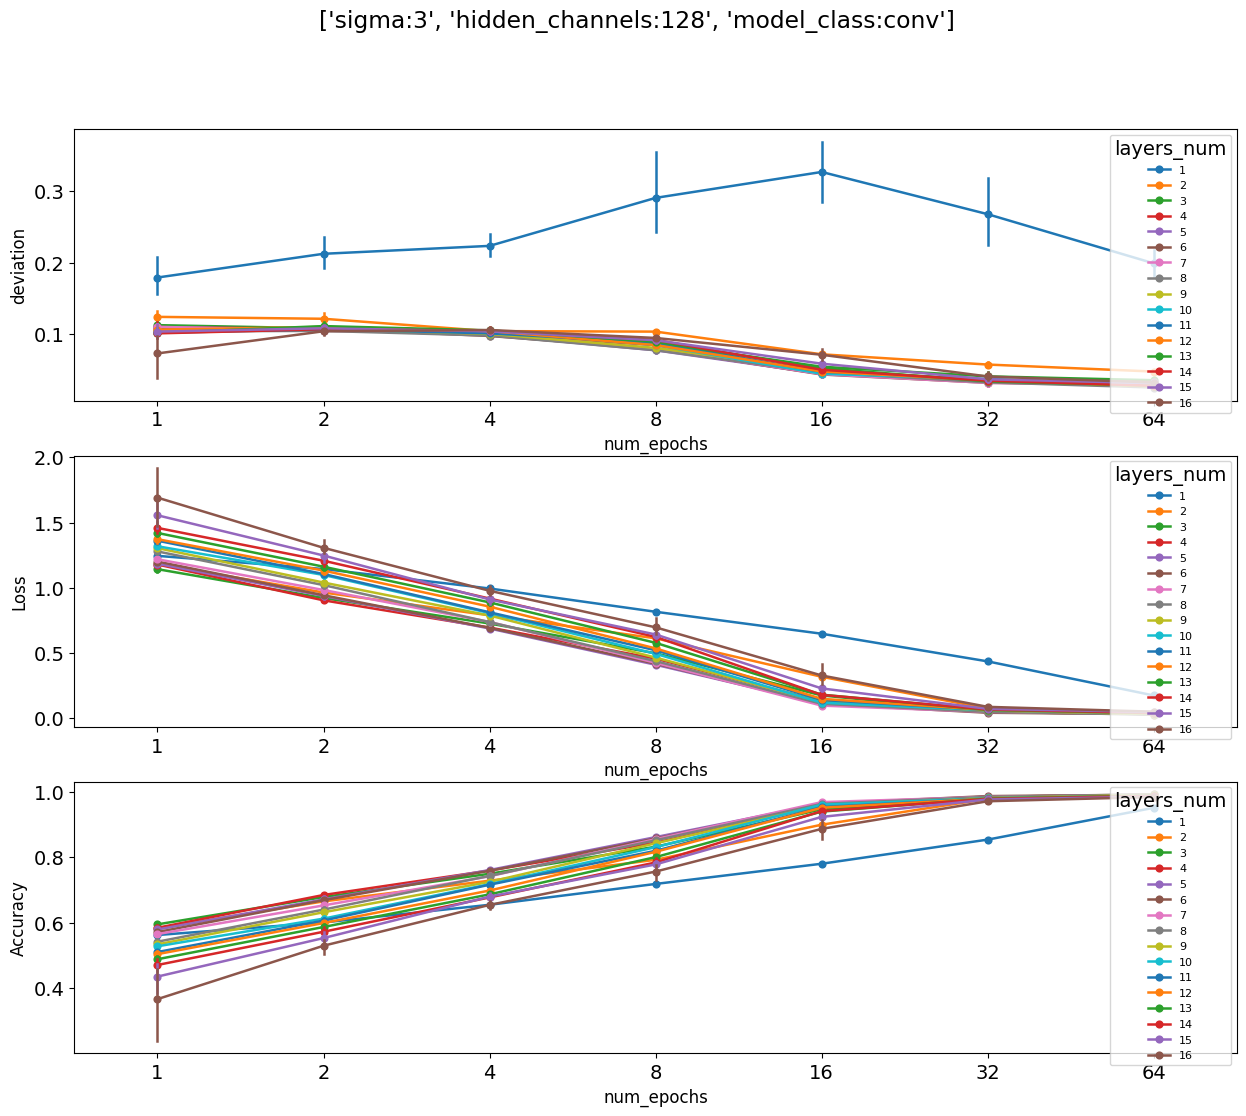

In [14]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'hidden_channels':128,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'layers_num'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])

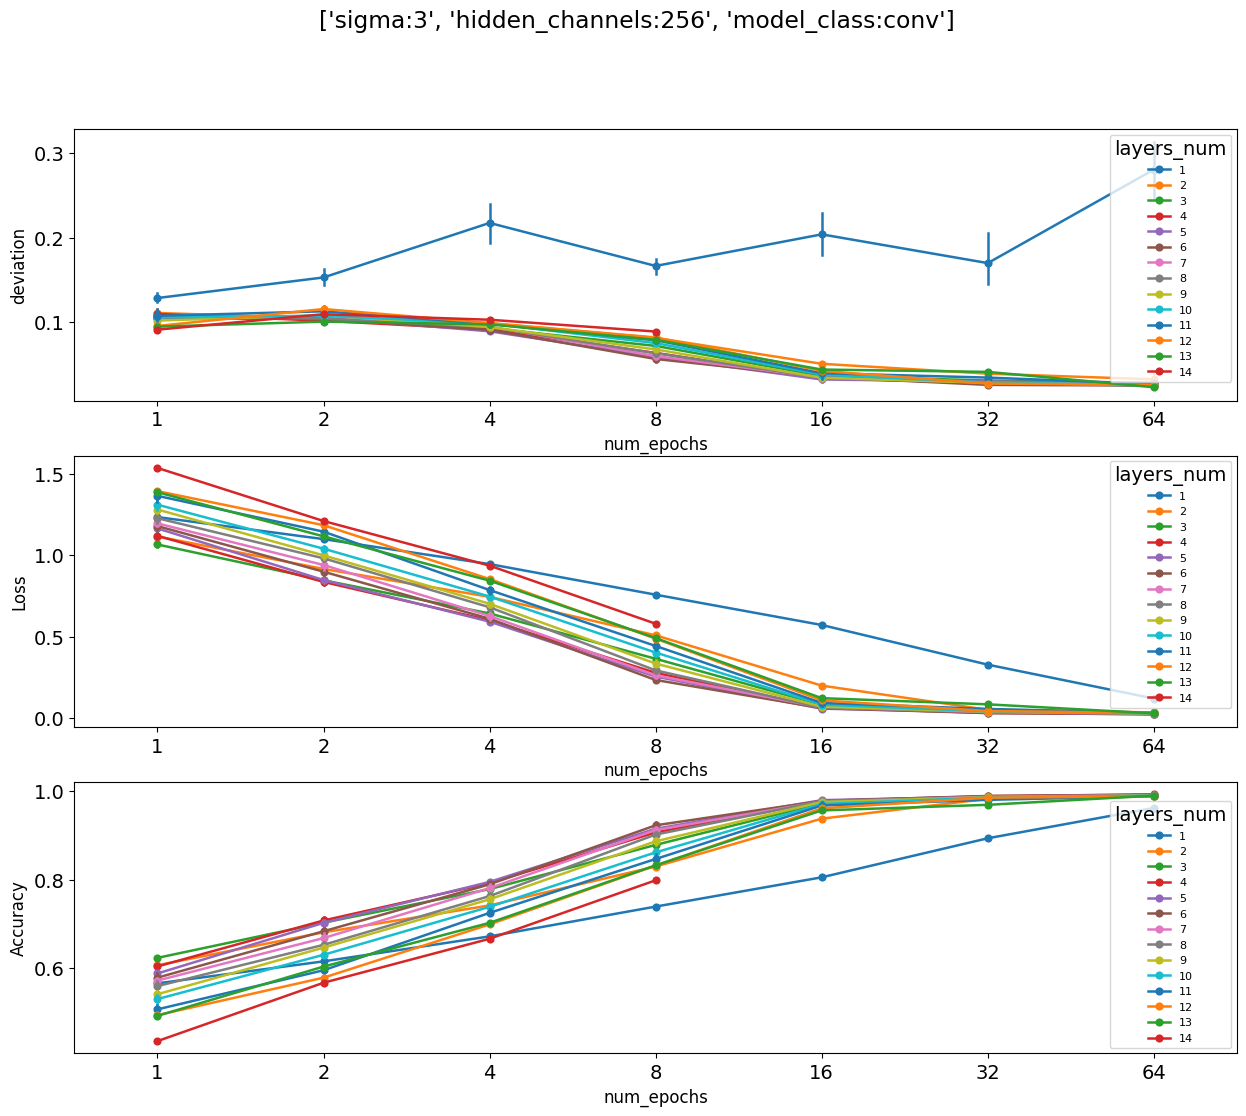

In [15]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'hidden_channels':256,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'layers_num'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])

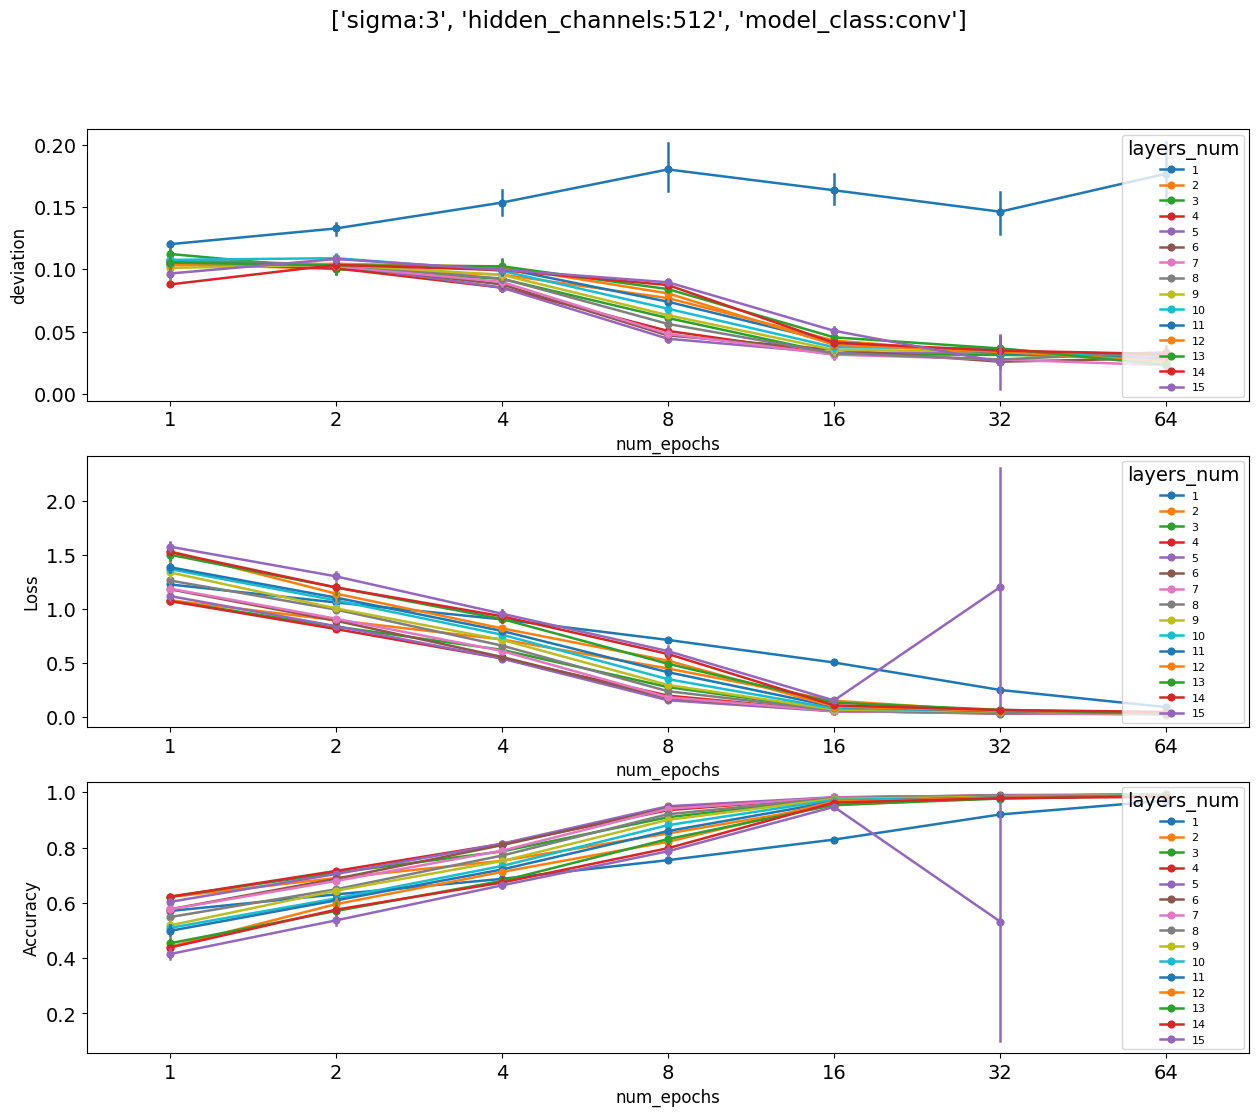

In [16]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'hidden_channels':512,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'layers_num'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])

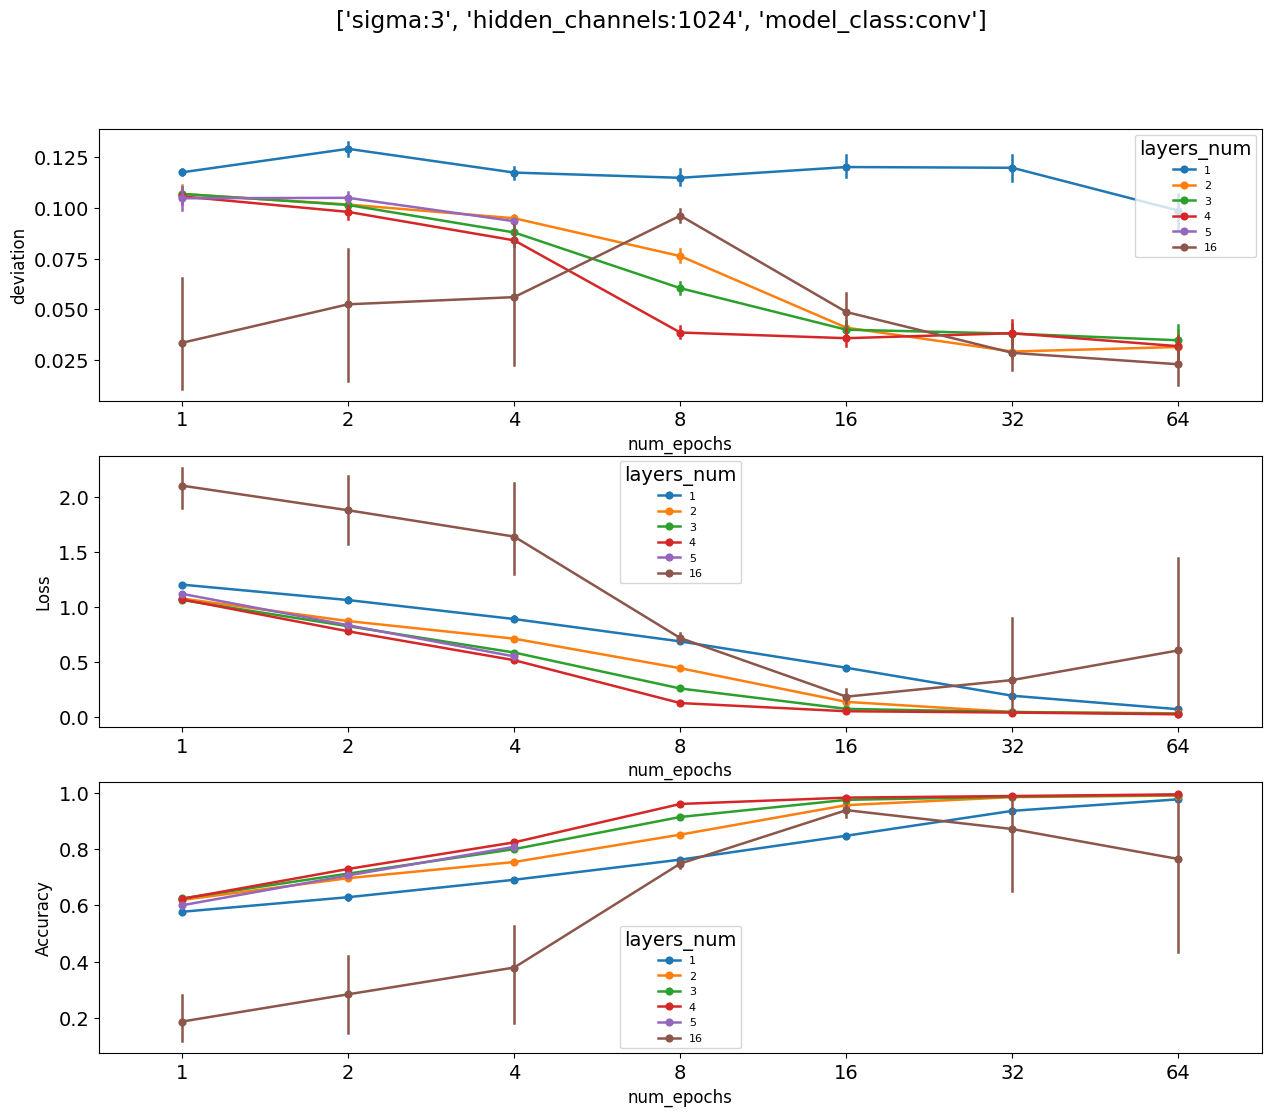

In [17]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'hidden_channels':1024,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'num_epochs'
supported_changes_params = 'layers_num'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])

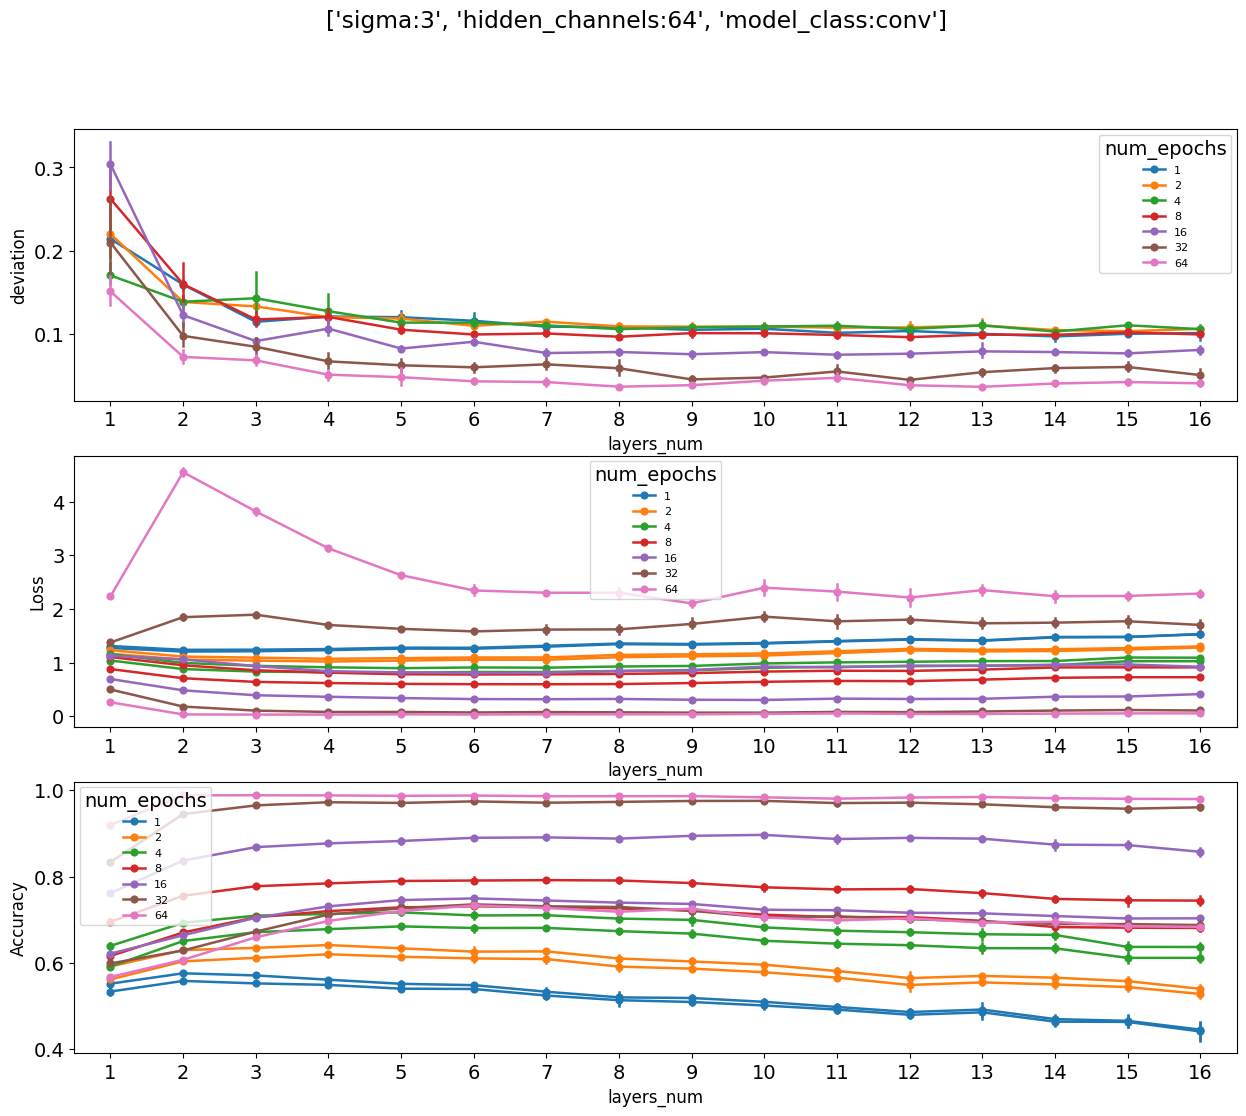

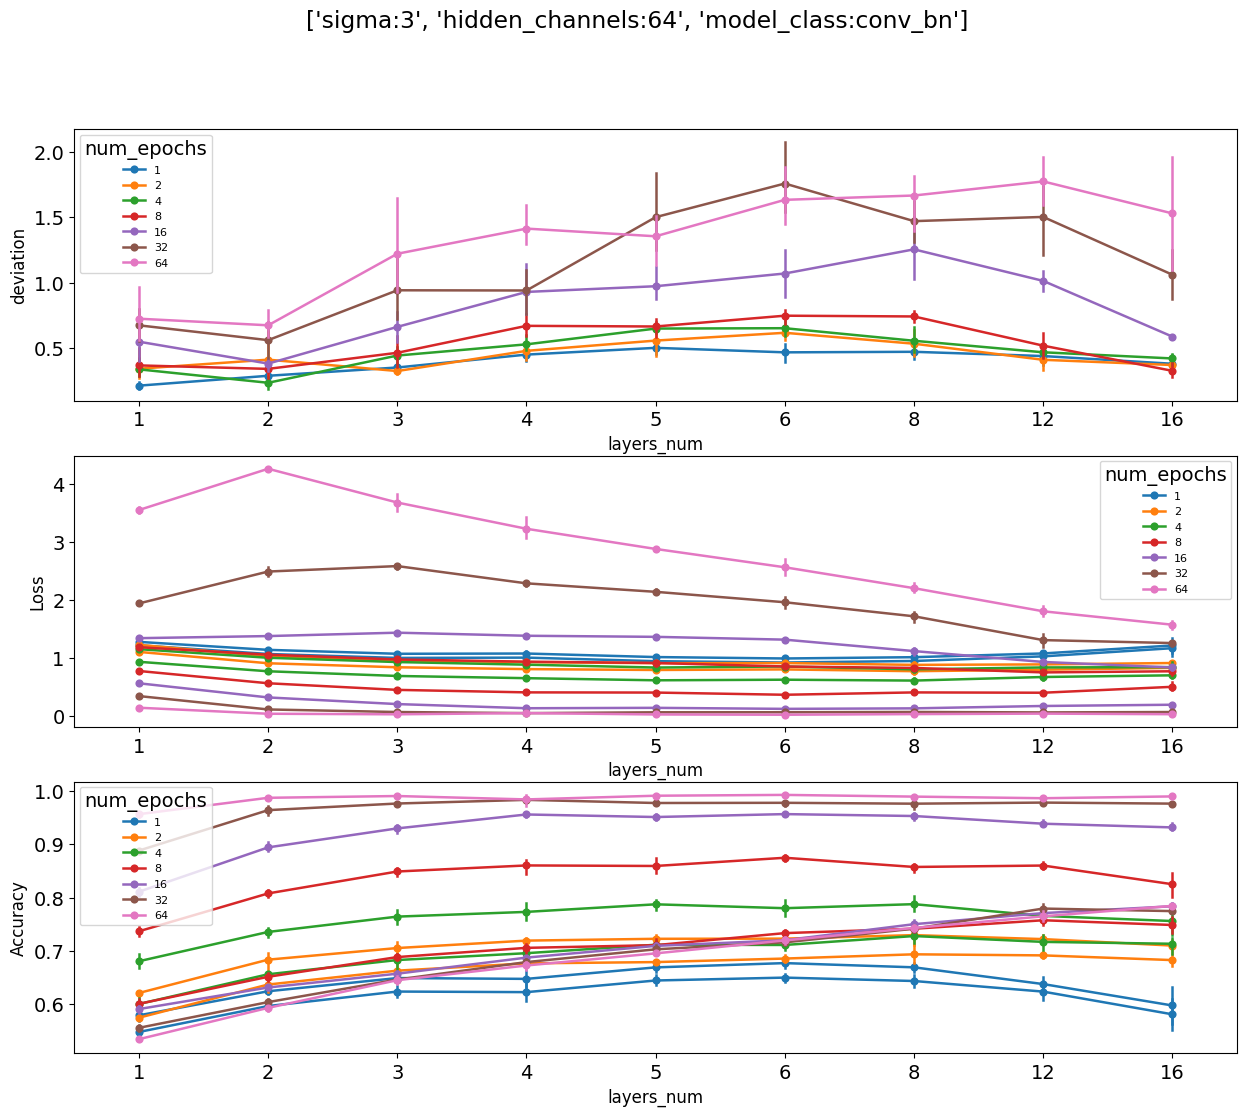

In [22]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'hidden_channels':64,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'layers_num'
supported_changes_params = 'num_epochs'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])


same_params = {
    'model_class':'conv_bn',
    
    'loader_size':-1,
    'hidden_channels':64,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'layers_num'
supported_changes_params = 'num_epochs'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=True, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])

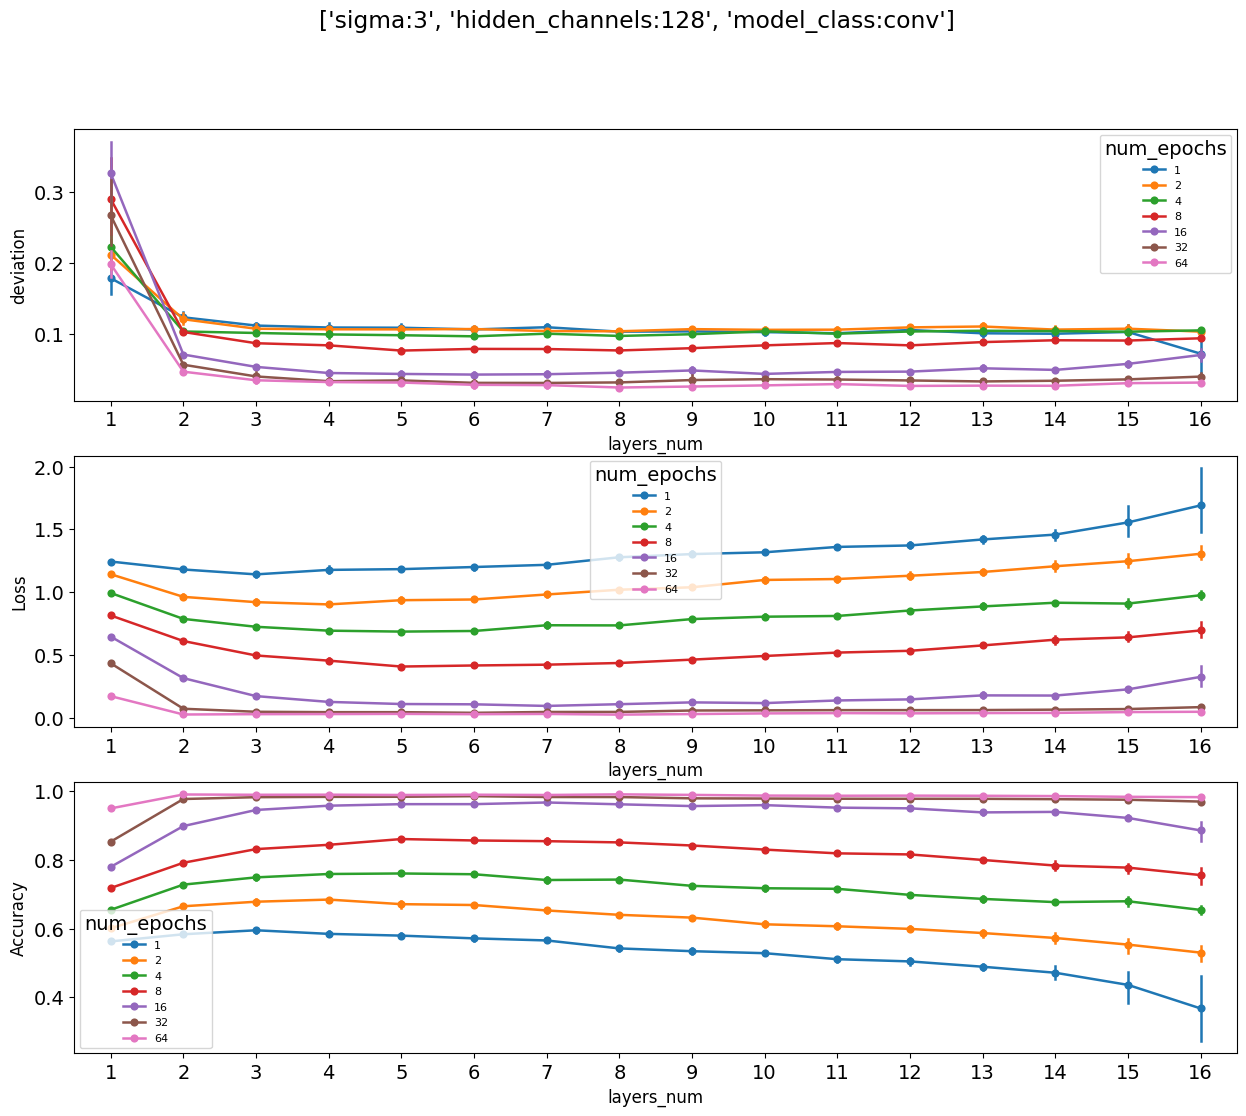

In [19]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'hidden_channels':128,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'layers_num'
supported_changes_params = 'num_epochs'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])

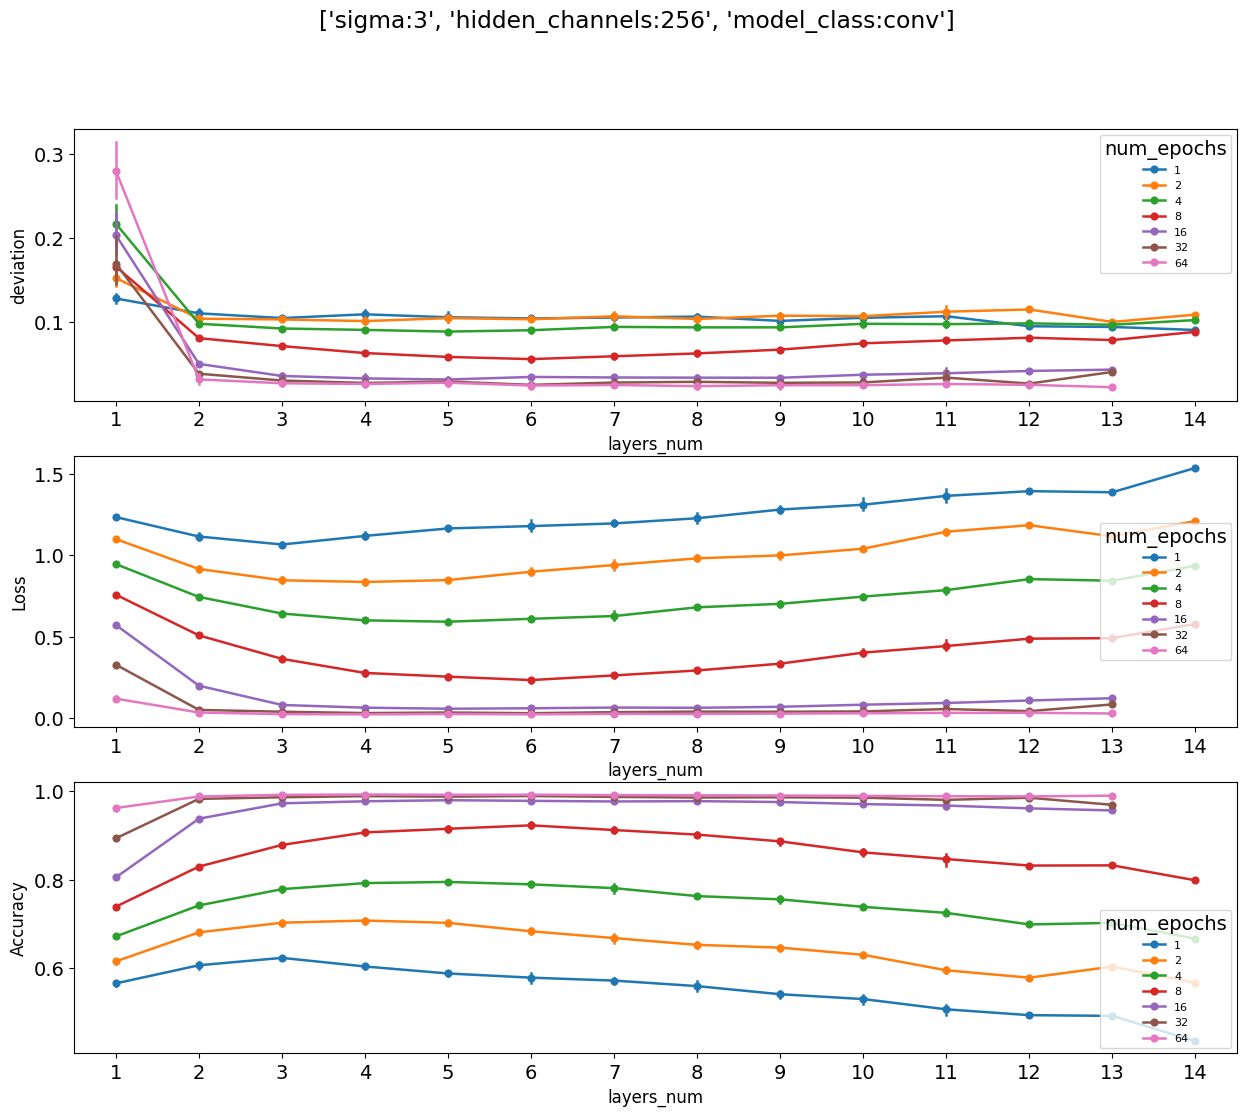

In [20]:
same_params = {
    'model_class':'conv',
    
    'loader_size':-1,
    'hidden_channels':256,
    'kernel_size':3,
    'output_channels':8,
    'sigma':3,
    'samples_num':32
}
target_params = 'layers_num'
supported_changes_params = 'num_epochs'

compare_same_params(same_params, 
                    target_params, 
                    supported_changes_params,
                    enable_valid=False, 
                    params_in_suptitle=['sigma', 'hidden_channels', 'model_class'])

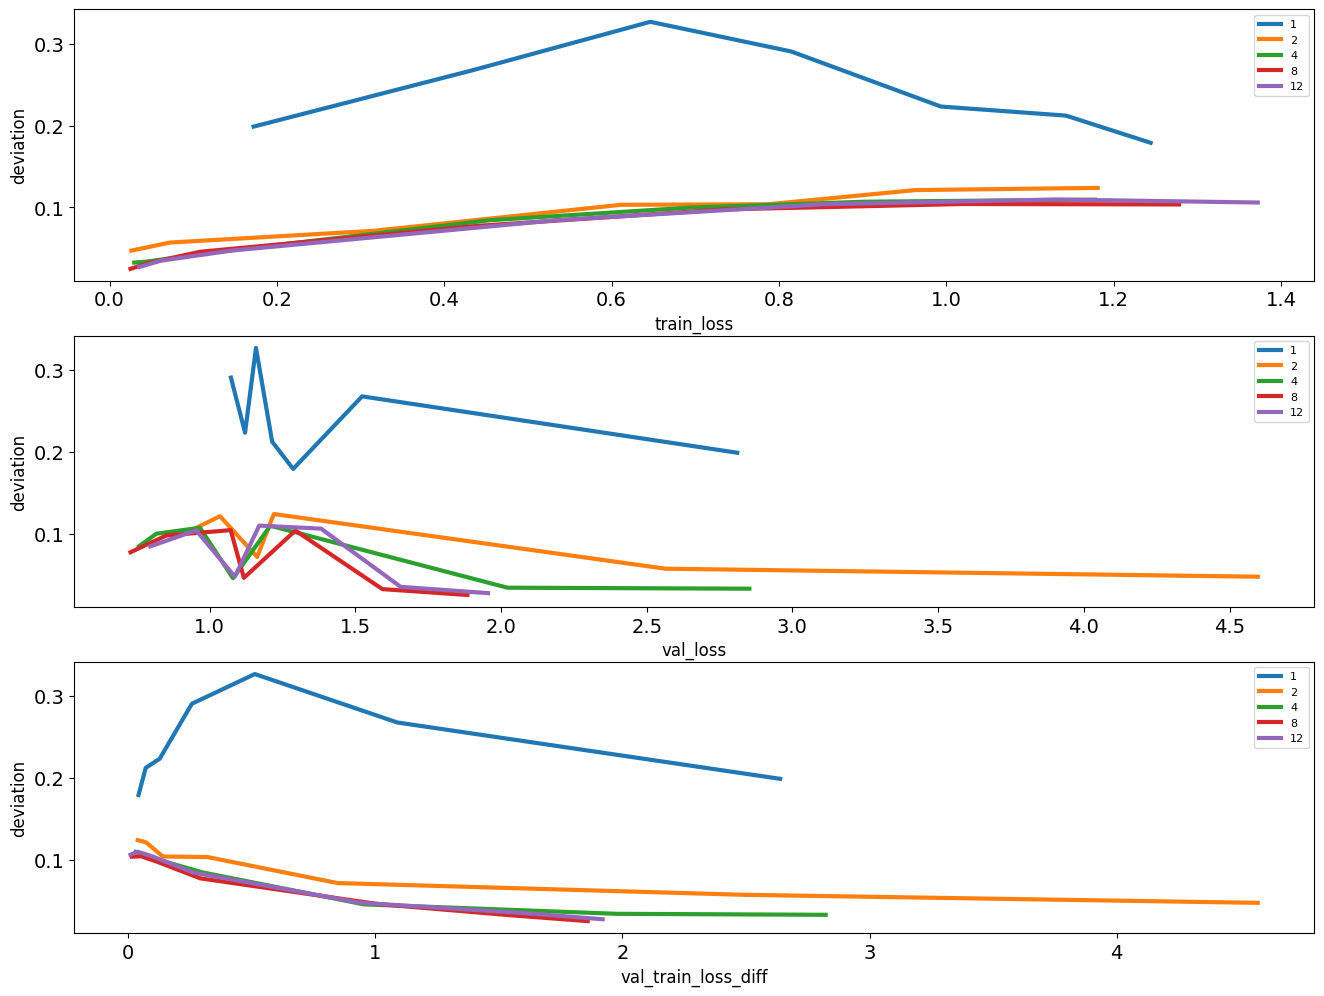

In [29]:
fig, axs = plt.subplots(3, figsize = (16, 12))
for i, l in enumerate([1, 2, 4, 8, 12]):
    t = df.query(f'layers_num == {l} and hidden_channels == 128')[['num_epochs', 'train_loss', 'val_loss', 'deviation', 'hidden_channels']]
    t = t.groupby(['num_epochs', 'hidden_channels']).mean().reset_index()
    t['val_train_loss_diff'] = t.val_loss - t.train_loss
    sns.lineplot(data = t, x = 'train_loss', y = 'deviation', label = f'{l}', ax = axs[0], lw = 3)
    sns.lineplot(data = t, x = 'val_loss', y = 'deviation', label = f'{l}', ax = axs[1], lw = 3)
    sns.lineplot(data = t, x = 'val_train_loss_diff', y = 'deviation', label = f'{l}', ax = axs[2], lw = 3)

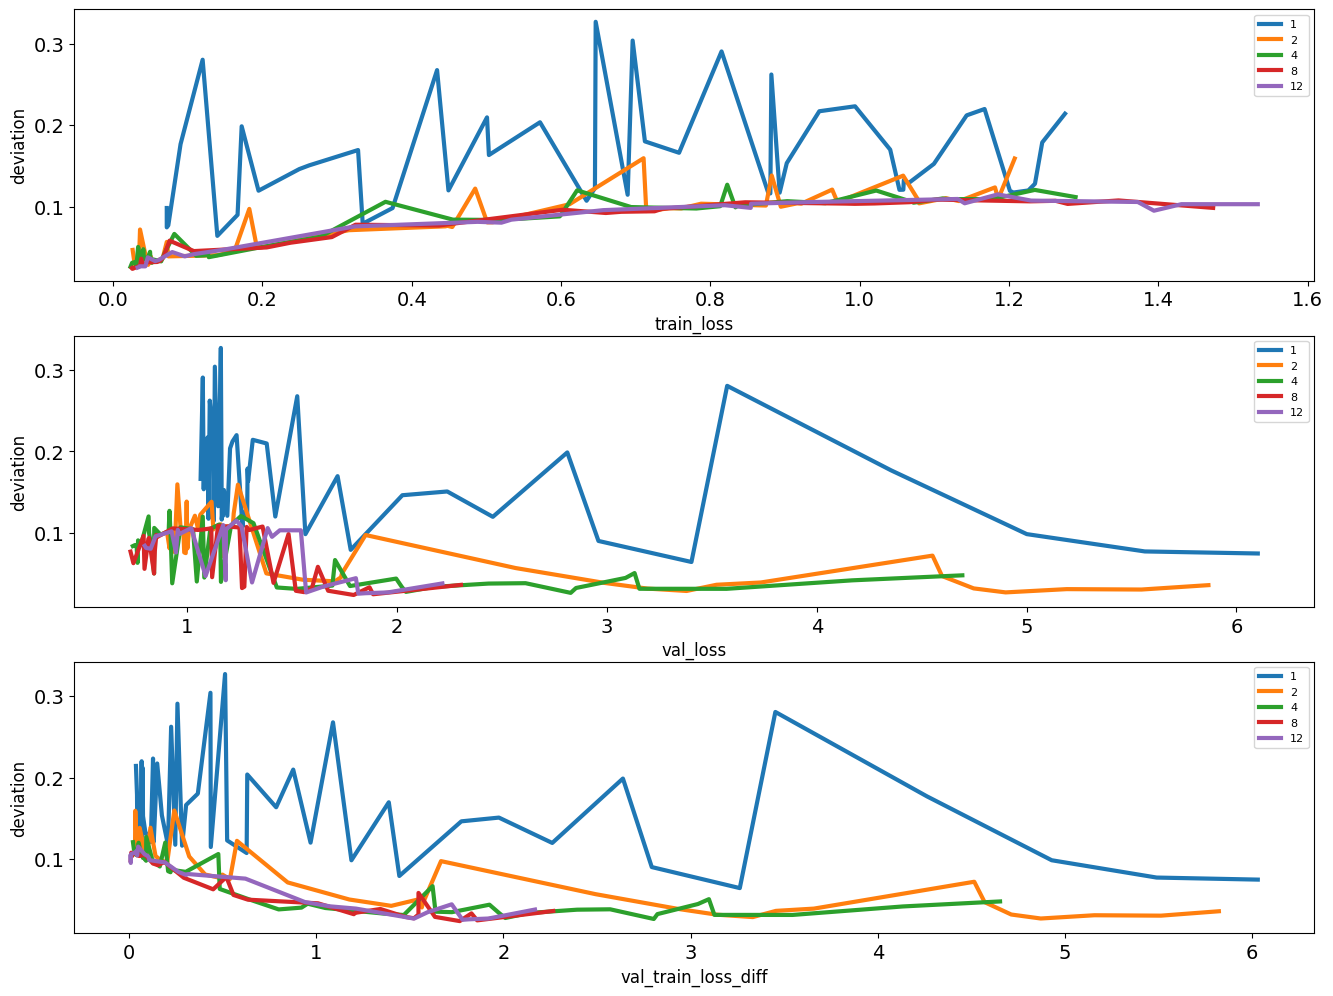

In [30]:
fig, axs = plt.subplots(3, figsize = (16, 12))
for i, l in enumerate([1, 2, 4, 8, 12]):
    t = df.query(f'layers_num == {l}')[['num_epochs', 'train_loss', 'val_loss', 'deviation', 'hidden_channels']]
    t = t.groupby(['num_epochs', 'hidden_channels']).mean().reset_index()
    t['val_train_loss_diff'] = t.val_loss - t.train_loss
    sns.lineplot(data = t, x = 'train_loss', y = 'deviation', label = f'{l}', ax = axs[0], lw = 3)
    sns.lineplot(data = t, x = 'val_loss', y = 'deviation', label = f'{l}', ax = axs[1], lw = 3)
    sns.lineplot(data = t, x = 'val_train_loss_diff', y = 'deviation', label = f'{l}', ax = axs[2], lw = 3)

In [8]:
df = df.copy()[df.layers_num == 4]

In [9]:
df.deviation.quantile(0.1)

0.03199755689580941

In [10]:
delta_interval = [df.deviation.quantile(q) for q in np.arange(0, 1, step = 0.1)]

In [11]:
import seaborn as sns

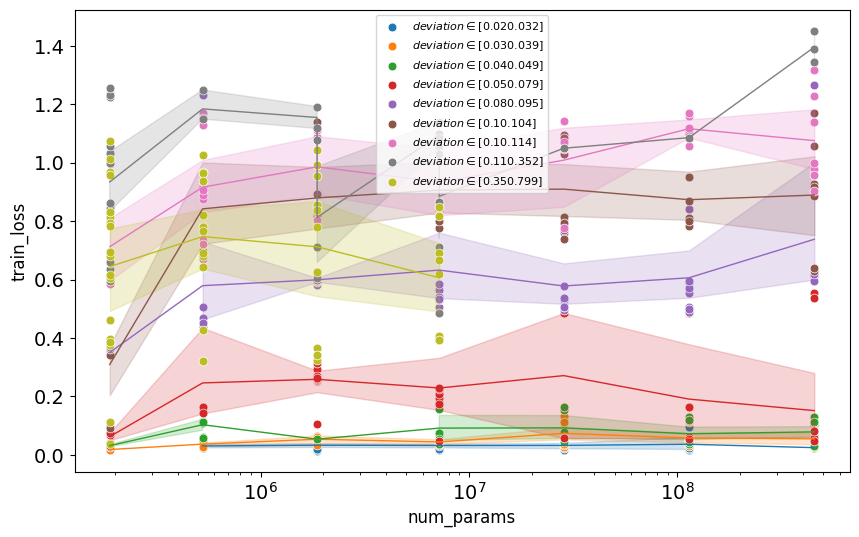

In [33]:
fig, ax = plt.subplots(figsize = (10, 6))
for delta_lb, delta_rb in zip(delta_interval[:-1], delta_interval[1:]):
    mask = ((df.deviation < delta_rb) & (df.deviation >= delta_lb))
    current_df = df[mask]
    current_df = current_df
    sns.scatterplot(data = current_df,
                    y = 'train_loss',
                    x = 'num_params',
                    label = f'$deviation \in [{np.round(delta_lb, 2)}{np.round(delta_rb, 3)}]$',
                    ax = ax, s = 40)
    sns.lineplot(data = current_df,
                y = 'train_loss',
                x = 'num_params')
    ax.set_xscale('log')

In [7]:
def get_criterion_sample_size(array, n_times = 64):
    array = array / np.arange(1, len(array)+1)
    return (np.where(array < array[0]/n_times)[0][0])
# 1 1/2 1 1/3 ...a

In [8]:
ans = []
for path in df.save_log_path:
    arr = pd.read_pickle(f'{path}/deviations_.pickle')
    ans.append(get_criterion_sample_size(arr))

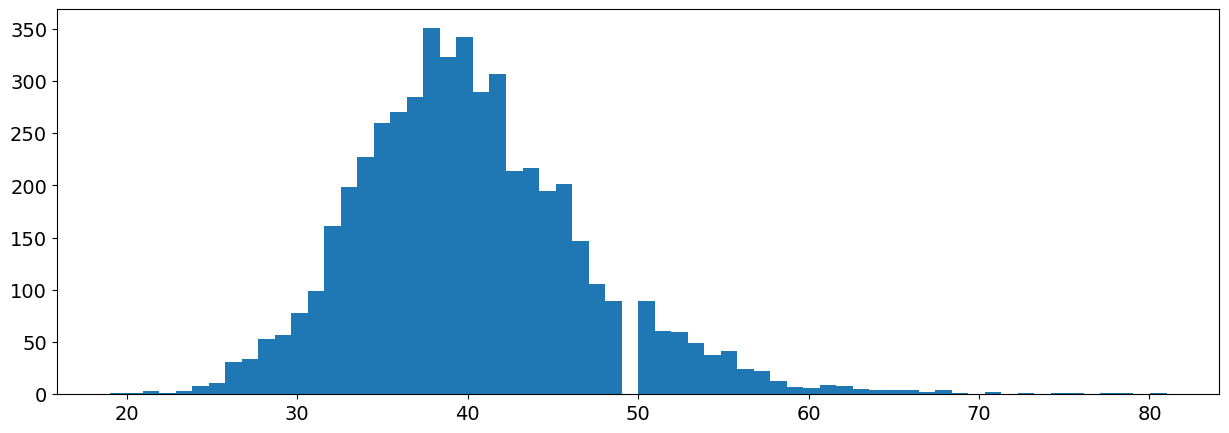

In [9]:
fig, axs = plt.subplots(figsize = (15, 5))
plt.hist(ans, bins = 64)
plt.show()

In [20]:
def get_criterion_v2_sample_size(array, n_times = 64):
    array = array / np.arange(1, len(array)+1)
    mask = (array < (array[0])/(n_times))
    for i in range(len(mask)):
        if np.all(mask[i:]):
            return i+1

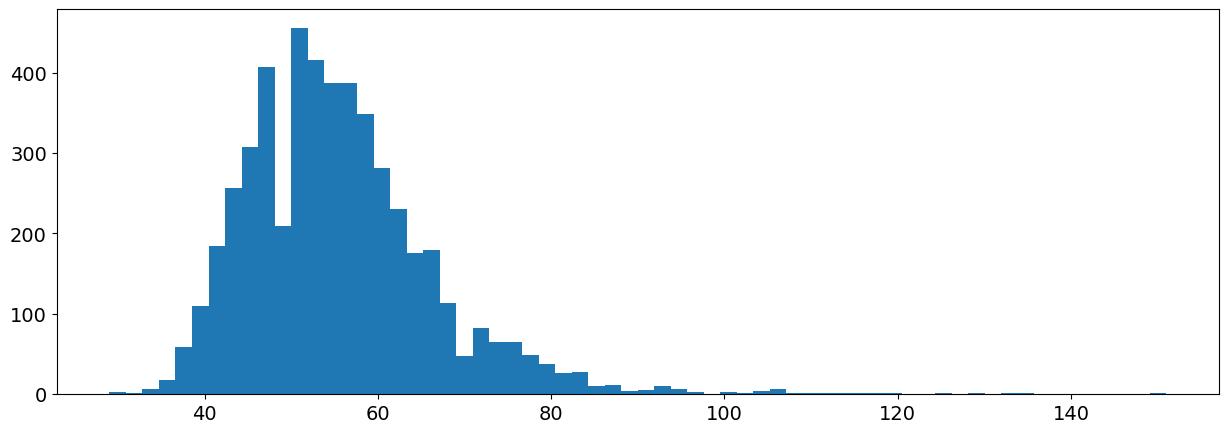

In [21]:
ans = []
for path in df.save_log_path:
    arr = pd.read_pickle(f'{path}/deviations_.pickle')
    ans.append(get_criterion_v2_sample_size(arr))

fig, axs = plt.subplots(figsize = (15, 5))
plt.hist(ans, bins = 64)
plt.show()

In [147]:
def get_criterion_v3_sample_size(array, n_times = 64):
    array = array / np.arange(1, len(array)+1)
    mask = (array < (array[1]+array[0])/(2*n_times))
    for i in range(len(mask)):
        if np.all(mask[i:]):
            return i+1

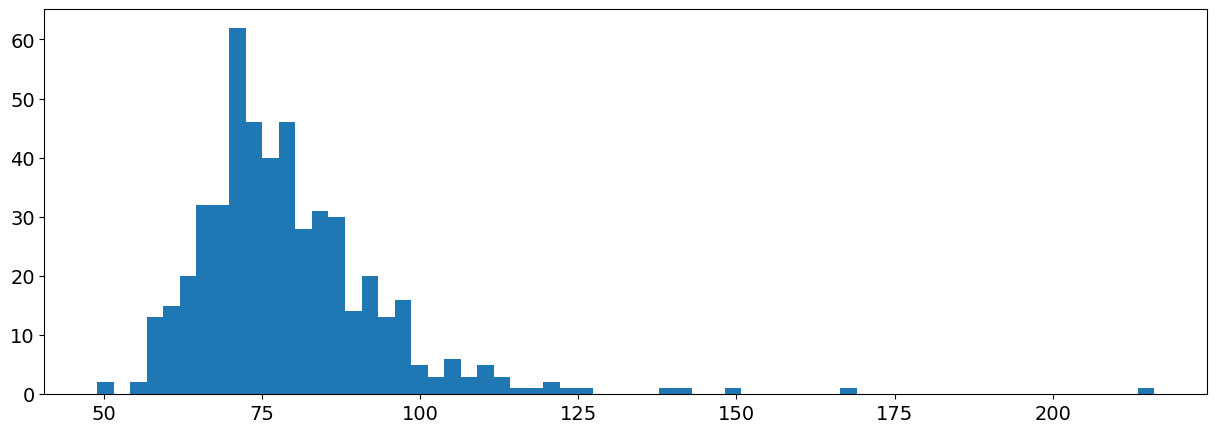

In [176]:
ans = []
all_arrs = []
for path in df.save_log_path:
    arr = pd.read_pickle(f'{path}/deviations_.pickle')
    all_arrs.extend(list(arr))
    ans.append(get_criterion_v3_sample_size(arr))

fig, axs = plt.subplots(figsize = (15, 5))
plt.hist(ans, bins = 64)
plt.show()

#### Если бы данная величина была нормальной:

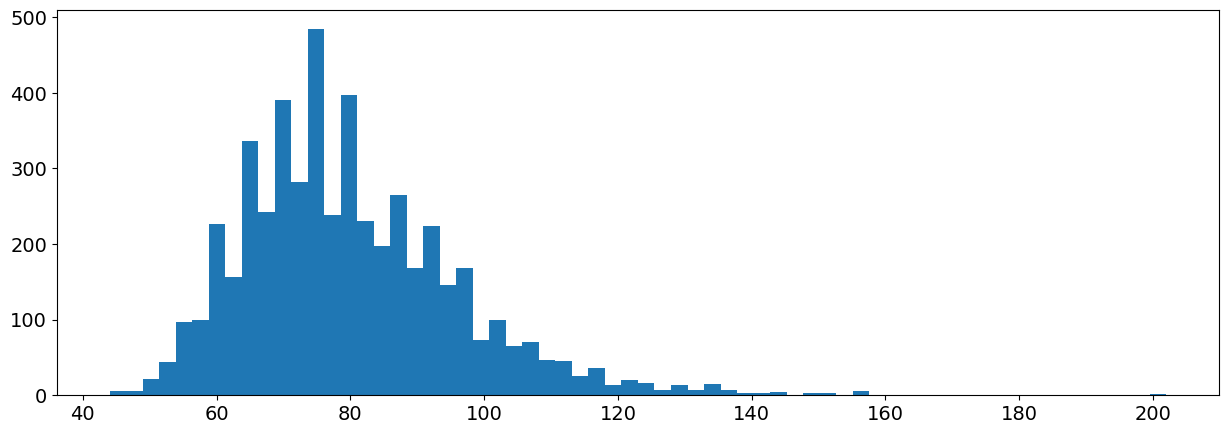

In [22]:
ans = []
for path in df.save_log_path:
    arr = np.random.randn(500)+6
    ans.append(get_criterion_v2_sample_size(arr))

fig, axs = plt.subplots(figsize = (15, 5))
plt.hist(ans, bins = 64)
plt.show()